In [2]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


## Evaluating the fit of stationary vs nonstationary gaussian processes
Fitting a stationary model helps avoid small eigenvlues when cov mat is computed with a small number of patches

In [3]:
# load images, extract patches, and compute cov mats
num_images = 15000
num_patches = 15000
num_test_set_patches = 5000
edge_crop = 32
patch_size = 15
num_patches_to_use = np.array([2, 10, 50, 250, 1250, 2500, 15000])
channel = 'DPC_Right'
# channel = 'LED119'


all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_set_patches, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_set_images = all_images[num_images:]
patches = extract_patches(images, patch_size, num_patches=num_patches)
test_set_patches = extract_patches(test_set_images, patch_size, num_patches=num_test_set_patches)

cov_mats = []
cov_mats_pd = []
non_stationary_means = []
cov_mats_stationary = []
cov_mats_stationary_pd = []
for n_patches in tqdm(num_patches_to_use):
    cov_mat = compute_cov_mat(patches[:n_patches])
    cov_mat_pd = make_positive_definite(cov_mat, eigenvalue_floor=1, show_plot=False)
    mean = np.mean(patches[:n_patches], axis=0).flatten()
    cov_mat_stationary = compute_stationary_cov_mat(patches[:n_patches])
    cov_mat_stationary_pd = make_positive_definite(cov_mat_stationary, eigenvalue_floor=1, show_plot=False)
    cov_mats.append(cov_mat)
    cov_mats_pd.append(cov_mat_pd)
    non_stationary_means.append(mean)
    cov_mats_stationary.append(cov_mat_stationary)
    cov_mats_stationary_pd.append(cov_mat_stationary_pd)

100%|██████████| 7/7 [00:18<00:00,  2.71s/it]


Text(0.5, 0.98, 'Eigenvalues of stationary and non-stationary covariance matrices vs dataset size')

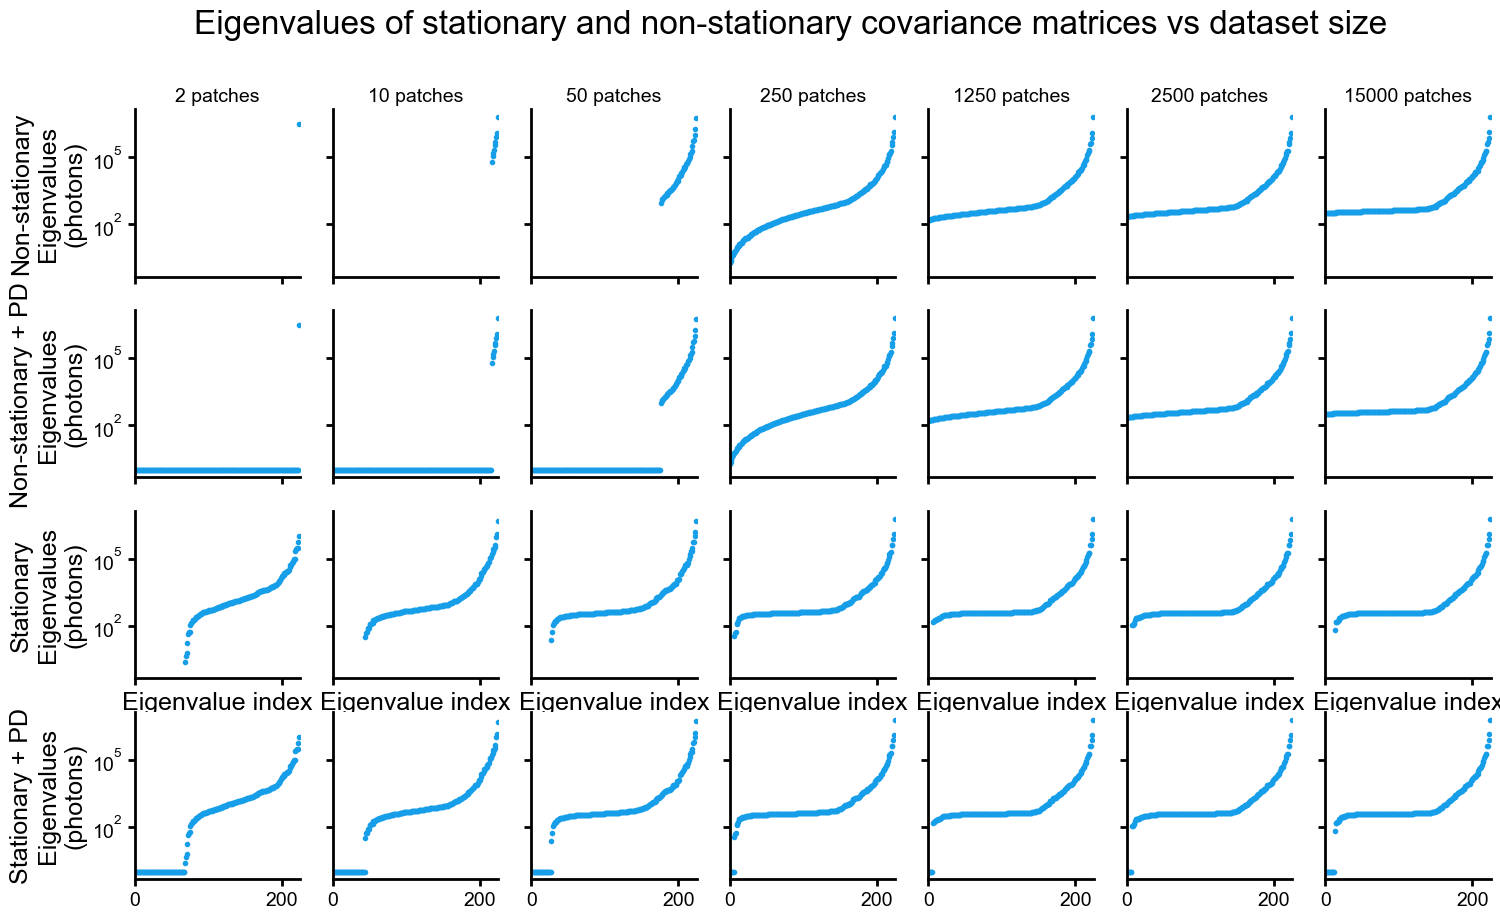

In [4]:
fig, ax = plt.subplots(4, num_patches_to_use.shape[0], figsize=(num_patches_to_use.shape[0] * 2.5, 10), sharex=True, sharey=True)

for i in range(len(cov_mats)):
    eigs = np.linalg.eigvalsh(cov_mats[i])
    eigs_pd = np.linalg.eigvalsh(cov_mats_pd[i])
    eigs_stationary = np.linalg.eigvalsh(cov_mats_stationary[i])
    eigs_stationary_pd = np.linalg.eigvalsh(cov_mats_stationary_pd[i])
    ax[0, i].semilogy(eigs, '.')
    ax[1, i].semilogy(eigs_pd, '.')
    ax[2, i].semilogy(eigs_stationary, '.')
    ax[3, i].semilogy(eigs_stationary_pd, '.')
    clear_spines(ax[0, i])
    clear_spines(ax[1, i])
    clear_spines(ax[2, i])
    clear_spines(ax[3, i])

    ax[0, i].set_title(f'{num_patches_to_use[i]} patches')
    if i == 0:
        ax[0, i].set_ylabel('Non-stationary\nEigenvalues\n(photons)')
        ax[1, i].set_ylabel('Non-stationary + PD\nEigenvalues\n(photons)')
        ax[2, i].set_ylabel('Stationary\nEigenvalues\n(photons)')
        ax[3, i].set_ylabel('Stationary + PD\nEigenvalues\n(photons)')
    ax[2, i].set(xlabel='Eigenvalue index', xlim=[0, len(eigs)])


fig.suptitle('Eigenvalues of stationary and non-stationary covariance matrices vs dataset size') 

### Compute likelihood on held out test set

In [5]:

test_data = test_set_patches.reshape(test_set_patches.shape[0], -1)
# compute log likelihood of test set
log_likelihoods_full_mean = []
log_likelihoods_full_confidence_interval = []
log_likelihoods_stationary_mean = []
log_likelihoods_stationary_confidence_interval = []
for i in tqdm(range(len(num_patches_to_use))):
    mean, interval = run_bootstrap(test_data, 
                                   lambda x: np.mean(jax.scipy.stats.multivariate_normal.logpdf(x, mean=non_stationary_means[i], cov=cov_mats_pd[i])), 
                                   num_bootstrap_samples=10, confidence_interval=90)
    log_likelihoods_full_mean.append(mean)
    log_likelihoods_full_confidence_interval.append(interval)

    mean, interval = run_bootstrap(test_data,
                                      lambda x: np.mean(jax.scipy.stats.multivariate_normal.logpdf(x,
                                     mean=np.mean(non_stationary_means[i]) * np.ones_like(non_stationary_means[i]), cov=cov_mats_stationary_pd[i])),
                                      num_bootstrap_samples=10, confidence_interval=90)
    log_likelihoods_stationary_mean.append(mean)
    log_likelihoods_stationary_confidence_interval.append(interval)

log_likelihoods_full_mean = np.array(log_likelihoods_full_mean)
log_likelihoods_full_confidence_interval = np.array(log_likelihoods_full_confidence_interval)
log_likelihoods_stationary_mean = np.array(log_likelihoods_stationary_mean)
log_likelihoods_stationary_confidence_interval = np.array(log_likelihoods_stationary_confidence_interval)


100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


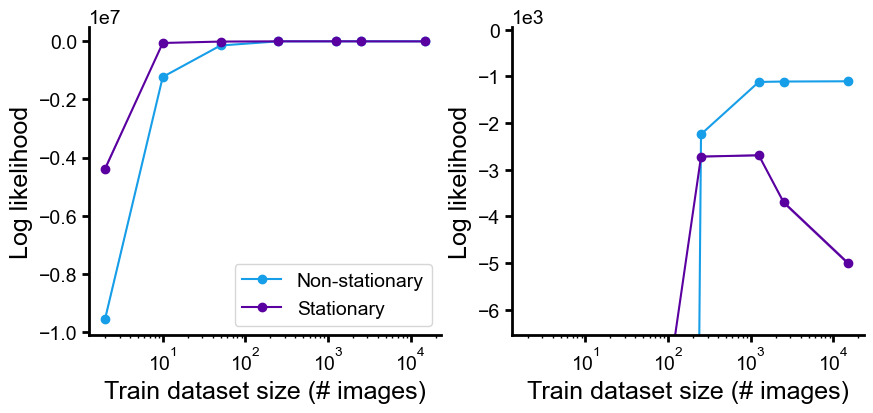

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# plot the log likelihoods of both on the same plot
ax[0].semilogx(num_patches_to_use, log_likelihoods_full_mean, 'o-', label='Non-stationary')
ax[0].semilogx(num_patches_to_use, log_likelihoods_stationary_mean, 'o-', label='Stationary')
ax[0].fill_between(num_patches_to_use, log_likelihoods_full_confidence_interval[:, 0], log_likelihoods_full_confidence_interval[:, 1], alpha=0.5)
ax[0].fill_between(num_patches_to_use, log_likelihoods_stationary_confidence_interval[:, 0], log_likelihoods_stationary_confidence_interval[:, 1], alpha=0.5)
ax[0].set(xlabel='Train dataset size (# images)', ylabel='Log likelihood')
ax[0].legend()
clear_spines(ax[0])

# zoom in on the top right 
ax[1].semilogx(num_patches_to_use, log_likelihoods_full_mean, 'o-', label='Non-stationary')
ax[1].semilogx(num_patches_to_use, log_likelihoods_stationary_mean, 'o-', label='Stationary')
ax[1].fill_between(num_patches_to_use, log_likelihoods_full_confidence_interval[:, 0], log_likelihoods_full_confidence_interval[:, 1], alpha=0.5)
ax[1].fill_between(num_patches_to_use, log_likelihoods_stationary_confidence_interval[:, 0], log_likelihoods_stationary_confidence_interval[:, 1], alpha=0.5)
ax[1].set(xlabel='Train dataset size (# images)', ylabel='Log likelihood')
# ax[1].legend()
clear_spines(ax[1])
# take the min and max of both plus a little extra to compute ylim
# ylim_max = np.max(np.concatenate([log_likelihoods_full_confidence_interval[3:], log_likelihoods_stationary_confidence_interval[3:]])) 
# ylim_min = np.min(np.concatenate([log_likelihoods_full_confidence_interval[3:], log_likelihoods_stationary_confidence_interval[3:]])) 
ylim_min = - 6e3
ylim_max = - 5e2
the_range = ylim_max - ylim_min
ax[1].set_ylim([ylim_min - 0.1 * the_range, ylim_max + 0.1 * the_range])
# make this one y labels in scientific notation also
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))


### Show samples from covariance matrices fit with different amounts of data

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 64.31it/s]
7it [00:00, 340.56it/s]


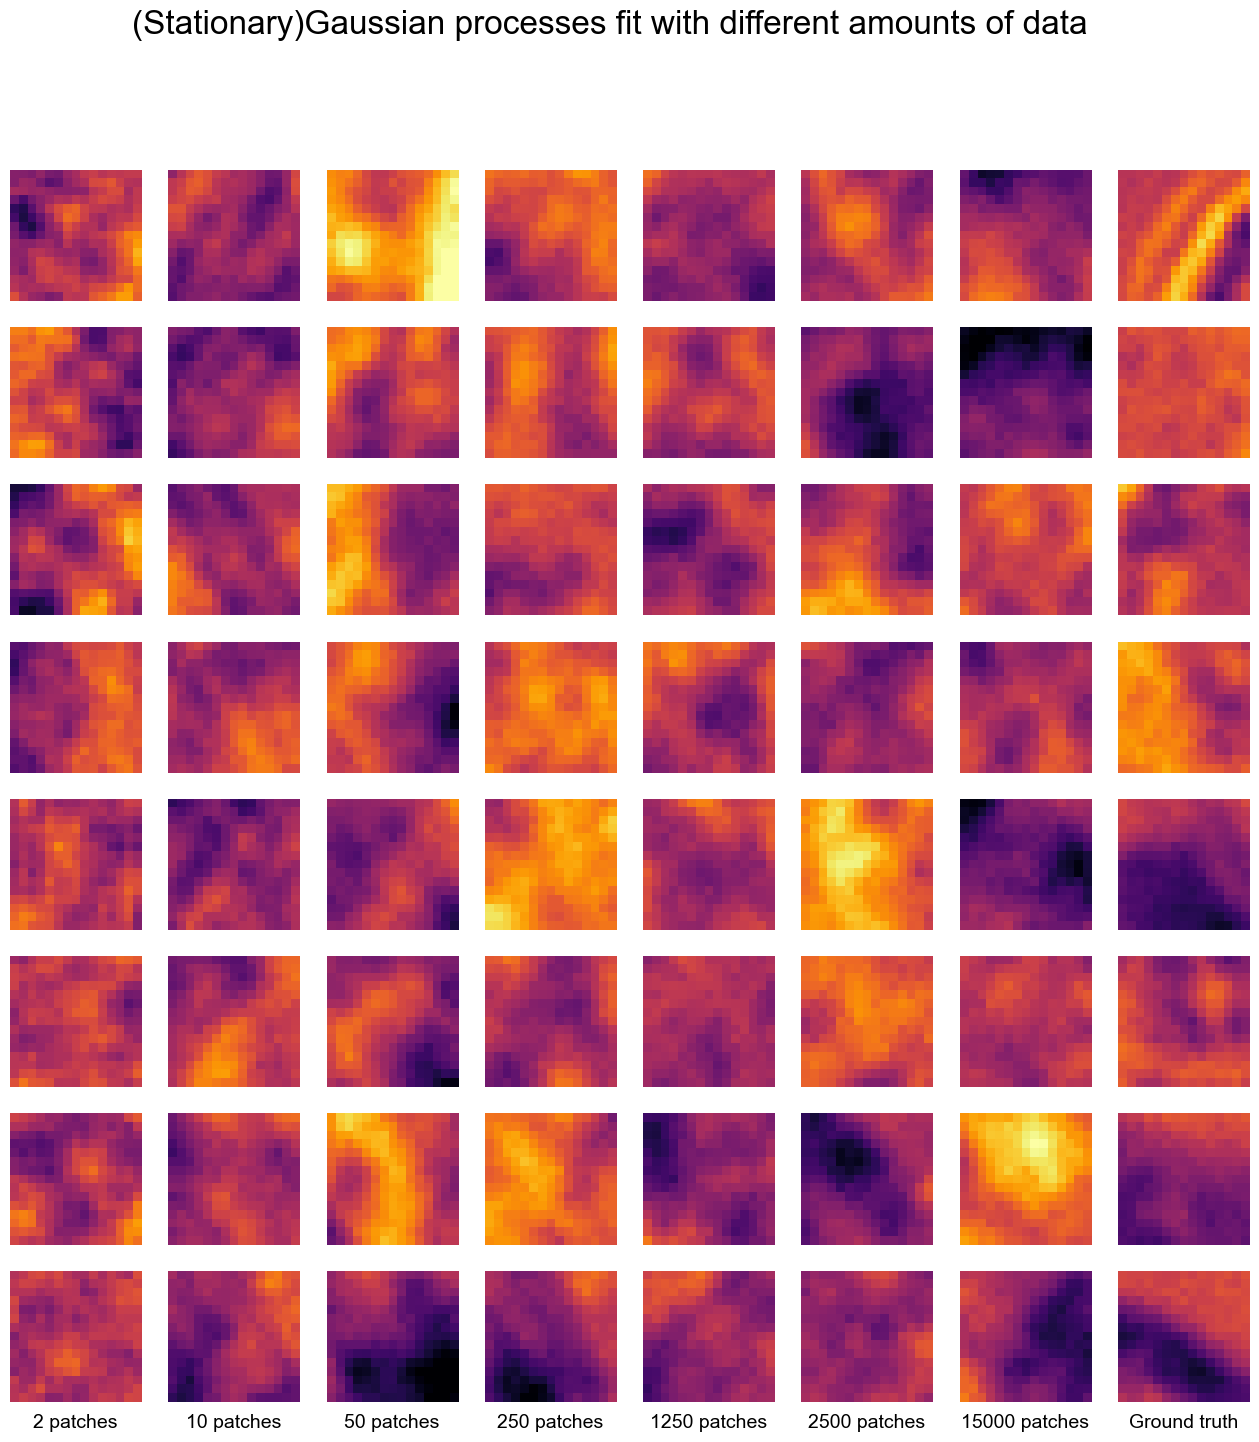

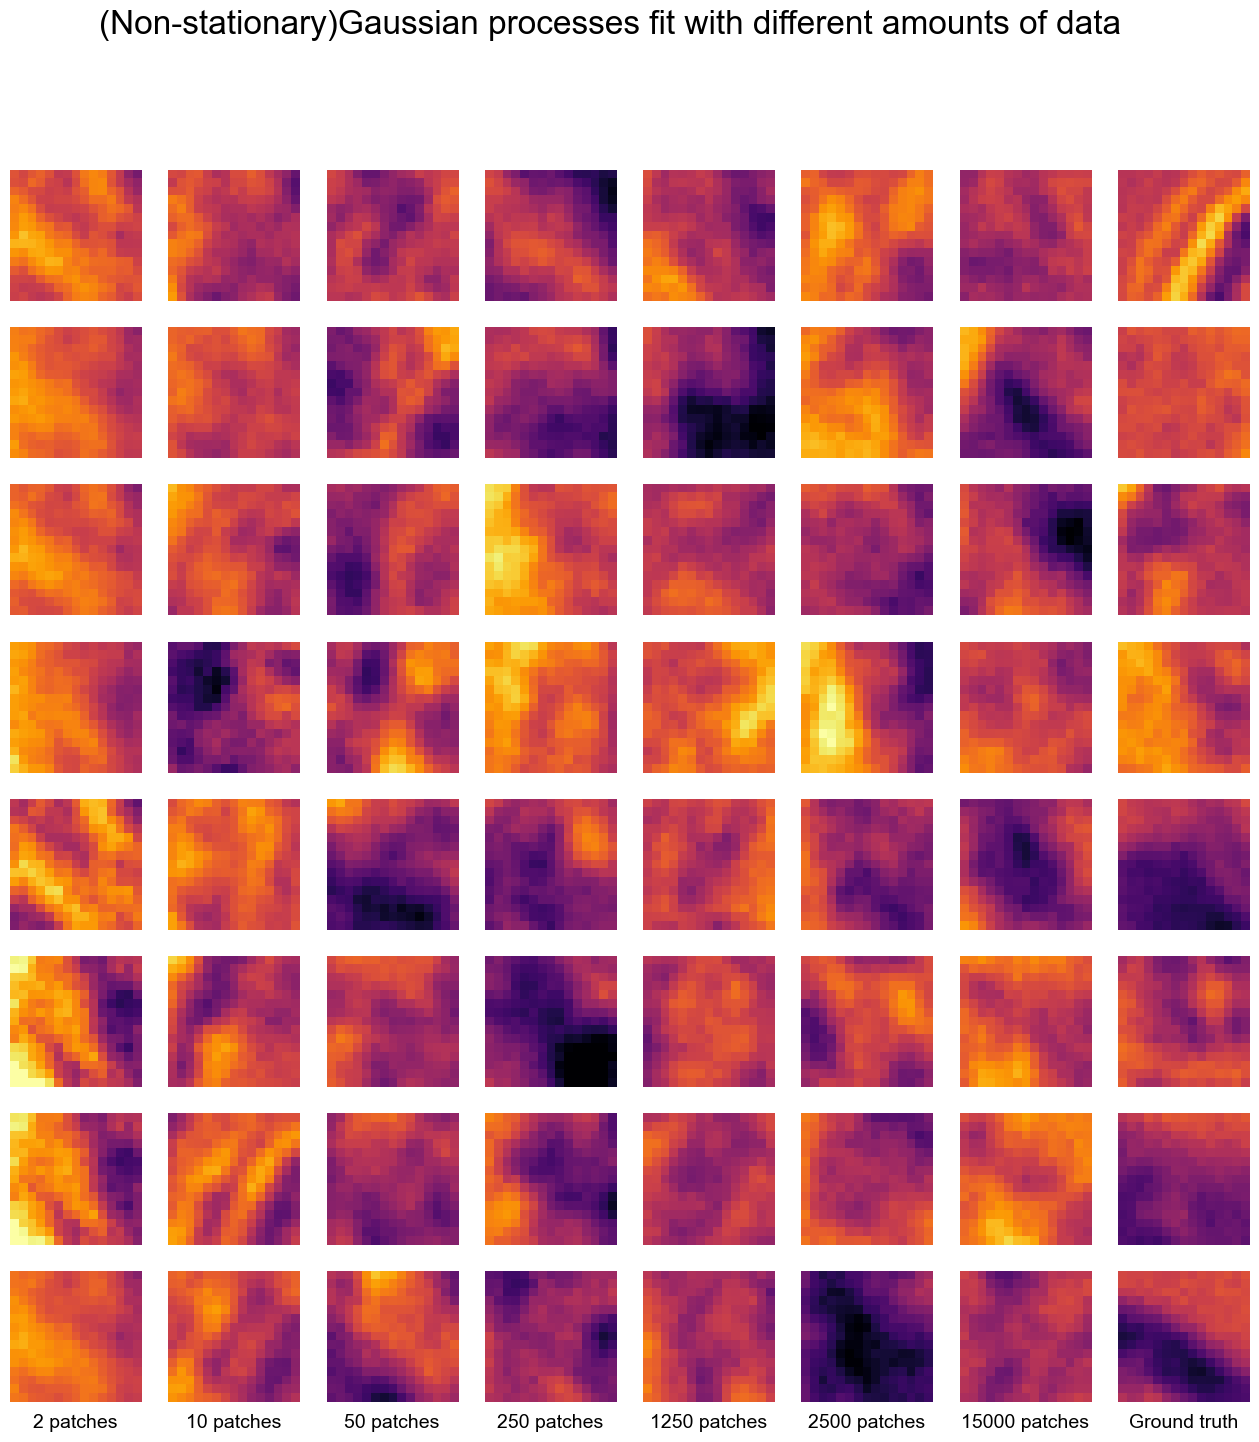

In [21]:
num_samples = 8
sample_size = patch_size

samples_stationary = []
for cov_mat in tqdm(cov_mats_stationary_pd):
    samples_stationary.append(generate_stationary_gaussian_process_samples(cov_mat, sample_size, num_samples, mean=np.mean(patches)))

samples_full = []
for cov_mat, mean in tqdm(zip(cov_mats_pd, non_stationary_means)):
    samples_full.append(generate_multivariate_gaussian_samples(cov_mat, num_samples, mean=mean))

for samples, prefix in zip([samples_stationary, samples_full], ['(Stationary)', '(Non-stationary)']):
    vmin, vmax = np.percentile(patches, 0.3), np.percentile(patches, 99.7)

    # plot samples
    fig, ax = plt.subplots(num_samples, len(cov_mats_pd) + 1, figsize=((len(cov_mats_pd) + 1) * 2, num_samples * 2), sharex=True, sharey=True)

    for i in range(num_samples):
        for j in range(len(cov_mats_pd)):
            ax[i, j].imshow(samples[j][i], cmap='inferno', vmin=vmin, vmax=vmax)
            clear_spines(ax[i, j])
            if i == num_samples - 1:
                ax[i, j].text(0.5, -0.2, f'{num_patches_to_use[j]} patches', ha='center', transform=ax[i, j].transAxes)
            ax[i, j].axis('off')
        ax[i, -1].imshow(patches[5:][i], cmap='inferno', vmin=vmin, vmax=vmax)
        ax[i, -1].axis('off')
        if i == num_samples - 1:
            ax[i, -1].text(0.5, -0.2, f'Ground truth', ha='center', transform=ax[i, -1].transAxes)

    fig.suptitle(f'{prefix}Gaussian processes fit with different amounts of data')

### TODO: How does the patch size of a stationary process affect ability to fit the data

In [30]:
# load images, extract patches, and compute cov mats
num_images = 10000
num_patches = 10000
num_test_set_patches = 5000
edge_crop = 32
# channel = 'DPC_Right'
channels = ['LED119', 'DPC_Right', 'Brightfield']
num_bootstrap_samples = 10

patch_sizes = np.array([2, 5, 8, 10, 12, 20, 32, 50])

log_likelihood_means_by_channel = {}
log_likelihood_confidence_intervals_by_channel = {}

for channel in channels:

    # all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_set_patches, edge_crop=edge_crop, median_filter=False)
    images = all_images[:num_images]
    test_set_images = all_images[num_images:]

    def compute_normalized_log_likelihood(images):       
        patches = extract_patches(images, patch_size, num_patches=num_patches, verbose=False)
        test_set_patches = extract_patches(test_set_images, patch_size, num_patches=num_test_set_patches, verbose=False)
        cov_mat_stationary = compute_stationary_cov_mat(patches)
        cov_mat_stationary_pd = make_positive_definite(cov_mat_stationary, eigenvalue_floor=1, show_plot=False)
        mean = np.ones(patch_size ** 2) * np.mean(patches)
        test_data = test_set_patches.reshape(test_set_patches.shape[0], -1)
        # compute log likelihood of test set
        return np.mean(jax.scipy.stats.multivariate_normal.logpdf(test_data, mean=mean, cov=cov_mat_stationary_pd))  / (patch_size ** 2)

    log_likelihood_means = []
    log_likelihood_confidence_intervals = []
    for patch_size in tqdm(patch_sizes):
        mean, interval = run_bootstrap(images, compute_normalized_log_likelihood, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=90)
        log_likelihood_means.append(mean)
        log_likelihood_confidence_intervals.append(interval)
    log_likelihood_means_by_channel[channel] = np.array(log_likelihood_means)
    log_likelihood_confidence_intervals_by_channel[channel] = np.array(log_likelihood_confidence_intervals)

  0%|          | 0/8 [00:00<?, ?it/s]


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


NameError: name 'channels' is not defined

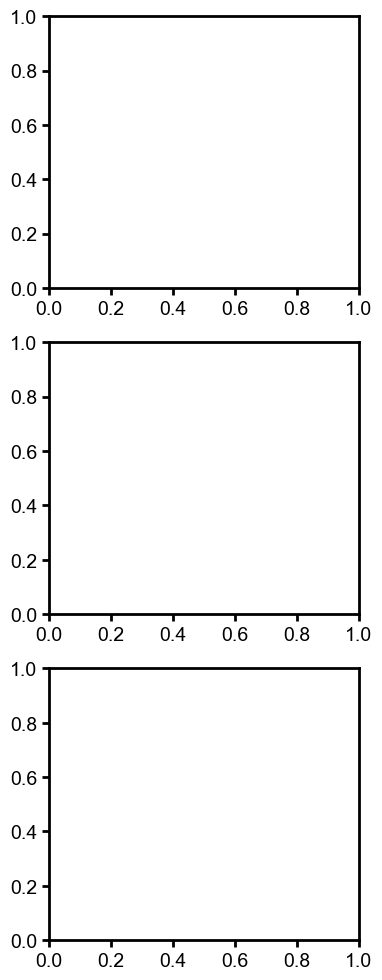

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(4, 12), sharex=True)
for i, channel in enumerate(channels):
    ax[i].plot(patch_sizes, log_likelihood_means, '.-')
    ax[i].fill_between(patch_sizes, log_likelihood_confidence_intervals[:, 0], log_likelihood_confidence_intervals[:, 1], alpha=0.5)
    ax[i].set(xlabel='Patch size', ylabel='Log likelihood per pixel')
    clear_spines(ax[i])
    ax[i].set_title(channel)

## Does the MI estimator correctly estimate MI for samples from a stationary process with known MI

stick to additive Gaussian noise, H(Y) can be computed analytically. The covariance matrix for p(y) is just the one for p(x) with sigma**2 * I added to it

In [33]:
# Compute a "true" reference covariance matrix
num_images = 5000
num_patches = 15000
edge_crop = 32
# patch_size = 50
patch_size = 10
channel = 'DPC_Right'


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=True)
patches = extract_patches(images, patch_size, num_patches=num_patches)
cov_mat = compute_cov_mat(patches)
cov_mat_pd = make_positive_definite(cov_mat, eigenvalue_floor=1, show_plot=False)
cov_mat_stationary = compute_stationary_cov_mat(patches)
cov_mat_stationary_pd = make_positive_definite(cov_mat_stationary, eigenvalue_floor=1, show_plot=False)


100%|██████████| 19/19 [00:00<00:00, 106.56it/s]


#### Verify that you can estimate a Covariance mat and its analytic entropy from samples of it

100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


Text(0.5, 1.0, 'Entropy error\nper pixel')

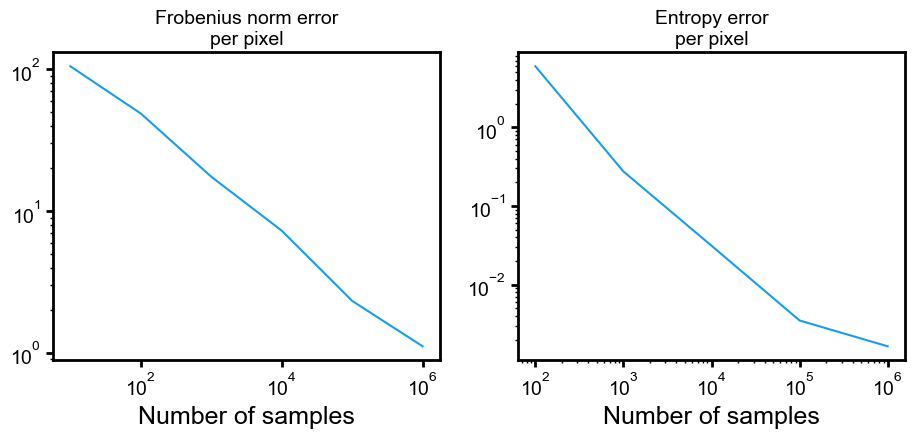

In [3]:
# now sample from the covariance matrix, estimate a new covart
seed = 0
num_samples_list = np.logspace(1, 6, 6, dtype=int)

mat_to_estimate = cov_mat
# mat_to_estimate = cov_mat_stationary_pd

true_entropy = analytic_multivariate_gaussian_entropy(mat_to_estimate) 

fro_norm_errors = []
entropy_errors = []
for num_samples in tqdm(num_samples_list):
    samples = jax.random.multivariate_normal(jax.random.PRNGKey(seed), np.zeros(mat_to_estimate.shape[0]), mat_to_estimate, shape=(num_samples,))
    cov_mat_estimate = compute_cov_mat(samples)
    # compute Frobenius norm of difference between cov_mat_estimate and cov_mat
    error = np.linalg.norm(cov_mat_estimate - mat_to_estimate, ord='fro') / mat_to_estimate.size
    fro_norm_errors.append(error)
    estimated_entropy = analytic_multivariate_gaussian_entropy(cov_mat_estimate) 
    entropy_error = np.abs(estimated_entropy - true_entropy)
    entropy_errors.append(entropy_error)

    
# plot errors
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].loglog(num_samples_list, fro_norm_errors)
ax[0].set_xlabel('Number of samples')
ax[0].set_title('Frobenius norm error\nper pixel')

ax[1].loglog(num_samples_list, entropy_errors)
ax[1].set_xlabel('Number of samples')
ax[1].set_title('Entropy error\nper pixel')


### Now verify that mutual information estimates converge to the true value with increasing number of samples

In [76]:
# Generate a ground truth covariance matrix for each channel, and then noiseless samples from it

num_images = 10000
num_patches = 50000
edge_crop = 32
# patch_size = 50
# TODO: full size?
patch_size = 12

channel = 'DPC_Right'


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=False)
patches = extract_patches(images, patch_size, num_patches=num_patches)

cov_mat = compute_cov_mat(patches)
cov_mat_stationary = compute_stationary_cov_mat(patches)
cov_mat_stationary_pd = make_positive_definite(cov_mat_stationary, eigenvalue_floor=1, show_plot=False)
true_cov_mat_px = cov_mat_stationary_pd
true_mean_px = np.mean(images)

samples = generate_stationary_gaussian_process_samples(cov_mat_stationary_pd, 
        sample_size=patch_size, num_samples=num_patches, mean=true_mean_px, ensure_nonnegative=True)

100%|██████████| 23/23 [00:00<00:00, 50.76it/s]


### Verify that entrpoy and mutual information estimates are consistent: they converge to the correct value given enough samples
Of course, this is on data that is sampled form a stationary gaussian process, so its only really showing that the gaussian approximation estimator can estimate gaussian entropy and MI. 

Running bootstraps: 100%|██████████| 100/100 [00:53<00:00,  1.85it/s]


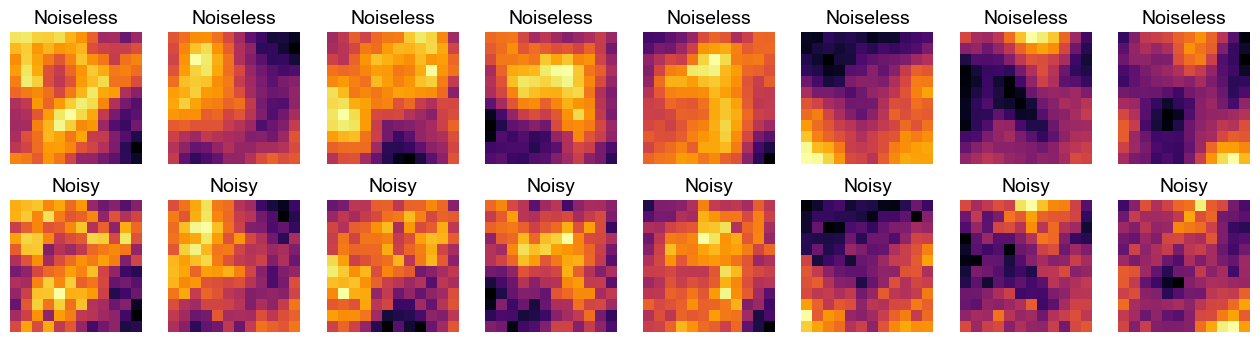

In [77]:
num_samples_to_use = np.array([4, 20, 100, 500, 2500, 5000, 10000, 20000])
num_bootstrap_samples = 100

# num_samples_to_use = np.array([4, 20, 2500])
# num_bootstrap_samples = 10

gaussian_sigma = 50
confidence_interval = 90

h_x_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_px) 
true_cov_mat_py = true_cov_mat_px + gaussian_sigma**2 * np.eye(patch_size**2)
h_y_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_py) 
# Constant conditional entropy for Gaussian noise
h_y_mid_x_analytic = analytic_multivariate_gaussian_entropy(np.eye(patch_size**2) * gaussian_sigma**2) 
mi_analytic_per_pixel = (h_y_analytic - h_y_mid_x_analytic) / np.log(2)

noisy_samples = add_noise(samples, gaussian_sigma=gaussian_sigma, ensure_positive=True)

# plot several samples and their corresponding noisy samples
num_to_show = 8
fig, ax = plt.subplots(2, num_to_show, figsize=(num_to_show * 2, 4))
for i in range(num_to_show):
    ax[0, i].imshow(samples[i].reshape(patch_size, patch_size), cmap='inferno')
    ax[1, i].imshow(noisy_samples[i].reshape(patch_size, patch_size), cmap='inferno')
    ax[0, i].set_title('Noiseless')
    ax[1, i].set_title('Noisy')
    ax[0,i].axis('off')
    ax[1,i].axis('off')


h_x_estimates_mean = []
h_x_estimates_conf_int = []
h_y_estimates_mean = []
h_y_estimates_conf_int = []
stationary_h_x_estimates_mean = []
stationary_h_x_estimates_conf_int = []
stationary_h_y_estimates_mean = []
stationary_h_y_estimates_conf_int = []
stationary_mi_estimates_mean = []
stationary_mi_estimates_conf_int = []

ev_floor = 1e-4
for num_to_use in num_samples_to_use:
    # estiamte noisy and noiseless entropies using stationary and non-stationary estimators
    mean, conf_int = run_bootstrap(samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                  lambda data: gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=ev_floor, show_plot=False), confidence_interval=confidence_interval )                  
    h_x_estimates_mean.append(mean)
    h_x_estimates_conf_int.append(conf_int)

    mean, conf_int = run_bootstrap(samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, show_plot=False), confidence_interval=confidence_interval )
    stationary_h_x_estimates_mean.append(mean)
    stationary_h_x_estimates_conf_int.append(conf_int)

    mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=ev_floor, show_plot=False), confidence_interval=confidence_interval )
    h_y_estimates_mean.append(mean)
    h_y_estimates_conf_int.append(conf_int)

    mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, show_plot=False), confidence_interval=confidence_interval)
    stationary_h_y_estimates_mean.append(mean)
    stationary_h_y_estimates_conf_int.append(conf_int)

    # estimate MI using stationary estimator
    mean, conf_int = run_bootstrap({'noisy_images': noisy_samples[:num_to_use], 'clean_images': samples[:num_to_use]}, 
                    num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                    lambda noisy_images, clean_images: estimate_mutual_information(noisy_images, clean_images, use_stationary_model=True,
                     eigenvalue_floor=ev_floor, gaussian_noise_sigma = gaussian_sigma, ) )
    stationary_mi_estimates_mean.append(mean)
    stationary_mi_estimates_conf_int.append(conf_int)


h_x_estimates_conf_int = np.array(h_x_estimates_conf_int)
h_x_estimates_mean = np.array(h_x_estimates_mean)
h_y_estimates_conf_int = np.array(h_y_estimates_conf_int)
h_y_estimates_mean = np.array(h_y_estimates_mean)
stationary_h_x_estimates_conf_int = np.array(stationary_h_x_estimates_conf_int)
stationary_h_x_estimates_mean = np.array(stationary_h_x_estimates_mean)
stationary_h_y_estimates_conf_int = np.array(stationary_h_y_estimates_conf_int)
stationary_h_y_estimates_mean = np.array(stationary_h_y_estimates_mean)
stationary_mi_estimates_conf_int = np.array(stationary_mi_estimates_conf_int)
stationary_mi_estimates_mean = np.array(stationary_mi_estimates_mean)

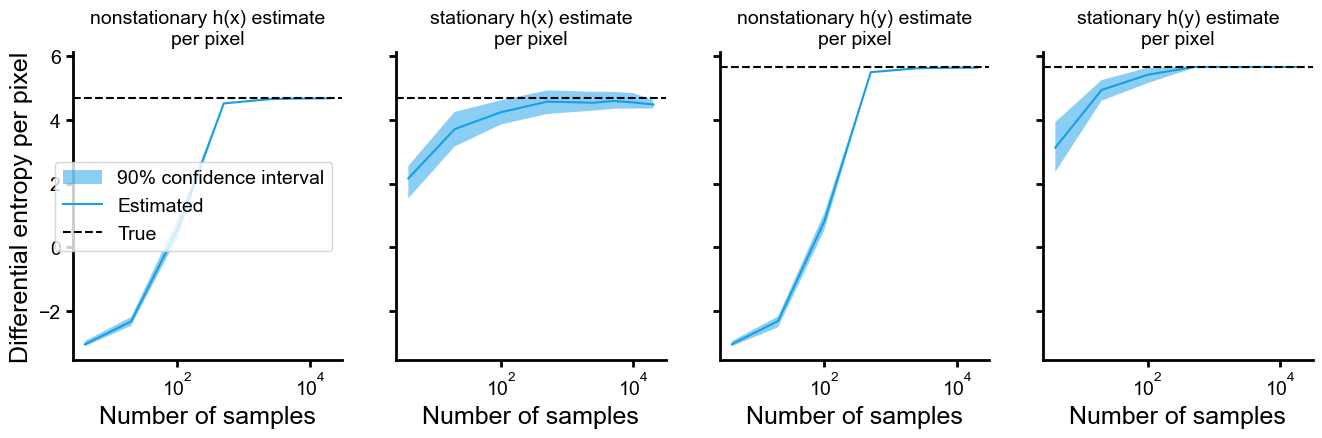

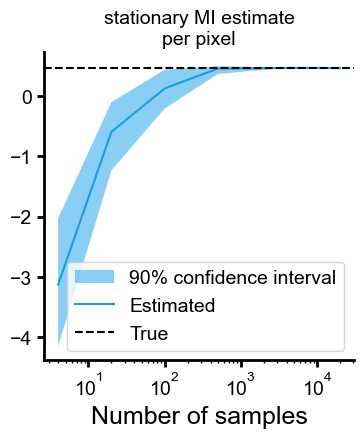

In [78]:
    
# plot estimates vs true value
fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)

ax[0].fill_between(num_samples_to_use, h_x_estimates_conf_int[:,0], h_x_estimates_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval')
ax[0].semilogx(num_samples_to_use, h_x_estimates_mean, label='Estimated')
ax[0].axhline(h_x_analytic, color='k', linestyle='--', label='True')
ax[0].set(xlabel='Number of samples', title='nonstationary h(x) estimate\nper pixel', ylabel='Differential entropy per pixel')
clear_spines(ax[0])
ax[0].legend()

ax[1].fill_between(num_samples_to_use, stationary_h_x_estimates_conf_int[:,0], stationary_h_x_estimates_conf_int[:,1], alpha=0.5)
ax[1].semilogx(num_samples_to_use, stationary_h_x_estimates_mean)
ax[1].axhline(h_x_analytic, color='k', linestyle='--')
ax[1].set(xlabel='Number of samples', title='stationary h(x) estimate\nper pixel')
clear_spines(ax[1])

ax[2].fill_between(num_samples_to_use, h_y_estimates_conf_int[:,0], h_y_estimates_conf_int[:,1], alpha=0.5)
ax[2].semilogx(num_samples_to_use, h_y_estimates_mean)
ax[2].axhline(h_y_analytic, color='k', linestyle='--')
ax[2].set(xlabel='Number of samples', title='nonstationary h(y) estimate\nper pixel')
clear_spines(ax[2])

ax[3].fill_between(num_samples_to_use, stationary_h_y_estimates_conf_int[:,0], stationary_h_y_estimates_conf_int[:,1], alpha=0.5)
ax[3].semilogx(num_samples_to_use, stationary_h_y_estimates_mean)
ax[3].axhline(h_y_analytic, color='k', linestyle='--')
ax[3].set(xlabel='Number of samples', title='stationary h(y) estimate\nper pixel')
clear_spines(ax[3])


fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.fill_between(num_samples_to_use, stationary_mi_estimates_conf_int[:,0], stationary_mi_estimates_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval')
ax.semilogx(num_samples_to_use, stationary_mi_estimates_mean, label='Estimated')
ax.axhline(mi_analytic_per_pixel, color='k', linestyle='--', label='True')
ax.set(xlabel='Number of samples', title='stationary MI estimate\nper pixel', ylabel='bits per pixel')
clear_spines(ax)
ax.legend()


### Make sure the cov mats look like what you expect

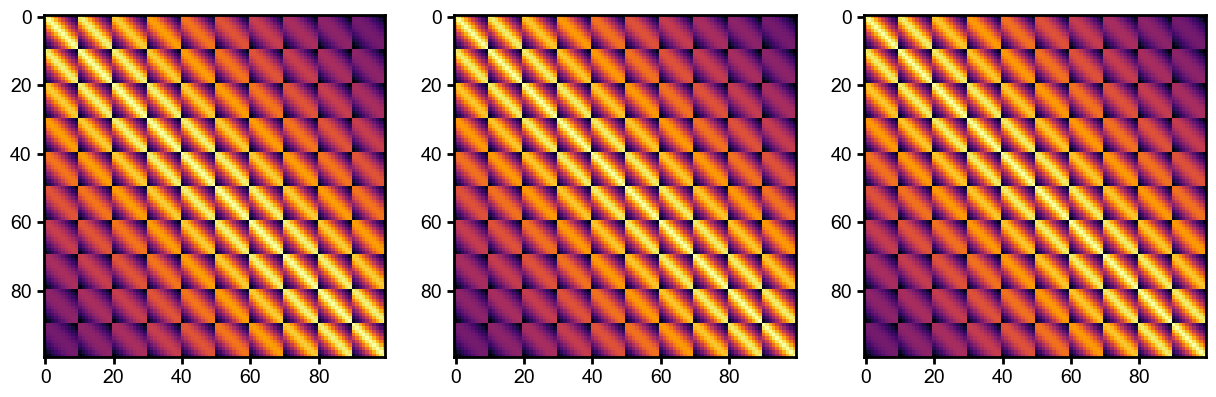

In [ ]:
_, cov_mat_full = gaussian_entropy_estimate(noisy_samples, stationary=False, eigenvalue_floor=ev_floor, show_plot=False, return_cov_mat=True)
_, cov_mat_stationary = gaussian_entropy_estimate(noisy_samples, stationary=True, eigenvalue_floor=ev_floor, show_plot=False, return_cov_mat=True)
cov_mat_stationary_pd = make_positive_definite(cov_mat_stationary, eigenvalue_floor=1, show_plot=False)

# imshow cov_mat_full
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(true_cov_mat_px, cmap='inferno')
ax[0].set_title('True covariance matrix')
ax[1].imshow(cov_mat_full, cmap='inferno')
ax[1].set_title('Estimated full covariance matrix')
ax[2].imshow(cov_mat_stationary, cmap='inferno')
ax[2].set_title('Estimated stationary covariance matrix')
ax[3].imshow(cov_mat_stationary_pd, cmap='inferno')
ax[3].set_title('Estimated stationary + PD covariance matrix')

## Is H(Y | X) well approximated by H(Y_theoretical | Y_experimental)

### Load images

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:31<00:00, 10.35s/it]


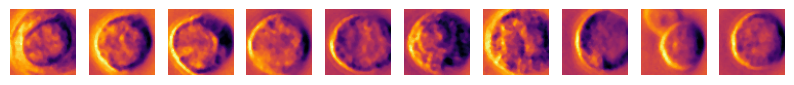

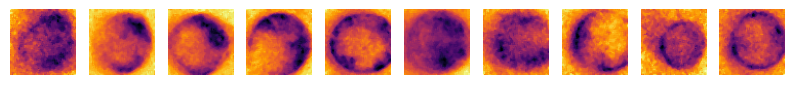

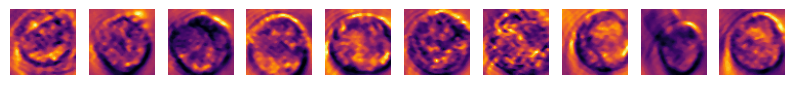

In [5]:
num_images = 10000
channels = ['DPC_Right', 'Brightfield', 'LED119']
# channels = ['LED119']

images = {}
clean_patches_by_channel = {}
for channel in tqdm(channels):
    # load "clean" median filtered images
    images[channel] = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=32, median_filter=True)        
    clean_patches_by_channel[channel] = extract_patches(images[channel], patch_size, num_patches=num_patches)

    # plot a montage of images
    num_to_plot = 10
    fig, ax = plt.subplots(1, num_to_plot, figsize=(num_to_plot, 1))
    for i in range(num_to_plot):
        ax[i].imshow(images[channel][i], cmap='inferno')
        ax[i].axis('off')

### Compare conditional entropy of noisy to clean

In [ ]:
estimate_mutual_information(noisy_patches)        

In [7]:
mean_photons = {channel: np.mean(images[channel]) for channel in images.keys()}
photons_per_pixel_list = [20, 40, 80, 160, 320]
num_bootstraps = 10
patch_size = 15
num_patches = 10000
confidence_interval = 90

results = {}
for channel in channels:
    results[channel] = []
    for photons_per_pixel in tqdm(photons_per_pixel_list):
        rescale_fractions = {channel: photons_per_pixel / mean_photons[channel] for channel in images.keys()}
        clean_patches = clean_patches_by_channel[channel] * rescale_fractions[channel]
        noisy_patches = add_noise(clean_patches, ensure_positive=True)

        noisy_conditional_mean, noisy_conditional_interval = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstraps, confidence_interval=confidence_interval, estimation_fn=
                                                             lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=True))
        clean_conditional_mean, clean_conditional_interval = run_bootstrap({'clean_images': clean_patches, 'noisy_images': noisy_patches},
                                                                            num_bootstrap_samples=num_bootstraps, confidence_interval=confidence_interval, estimation_fn=
                                                                lambda noisy_images, clean_images: estimate_mutual_information(noisy_images=noisy_images, clean_images=clean_images, verbose=True))
        results[channel].append((noisy_conditional_mean, noisy_conditional_interval, clean_conditional_mean, clean_conditional_interval))
        

  0%|          | 0/5 [00:00<?, ?it/s]

Estimated H(Y|X) = 4.682 bits/pixel
Estimated H(Y) = 4.361 bits/pixel
Estimated I(Y;X) = -0.321 bits/pixel


Estimated H(Y|X) = 4.682 bits/pixel
Estimated H(Y) = 4.360 bits/pixel
Estimated I(Y;X) = -0.322 bits/pixel


Estimated H(Y|X) = 4.680 bits/pixel
Estimated H(Y) = 4.360 bits/pixel
Estimated I(Y;X) = -0.320 bits/pixel


Estimated H(Y|X) = 4.680 bits/pixel
Estimated H(Y) = 4.360 bits/pixel
Estimated I(Y;X) = -0.320 bits/pixel


Estimated H(Y|X) = 4.680 bits/pixel
Estimated H(Y) = 4.359 bits/pixel
Estimated I(Y;X) = -0.321 bits/pixel


Estimated H(Y|X) = 4.679 bits/pixel
Estimated H(Y) = 4.359 bits/pixel
Estimated I(Y;X) = -0.320 bits/pixel


Estimated H(Y|X) = 4.680 bits/pixel
Estimated H(Y) = 4.359 bits/pixel
Estimated I(Y;X) = -0.321 bits/pixel


Estimated H(Y|X) = 4.680 bits/pixel
Estimated H(Y) = 4.359 bits/pixel
Estimated I(Y;X) = -0.321 bits/pixel


Estimated H(Y|X) = 4.683 bits/pixel
Estimated H(Y) = 4.362 bits/pixel
Estimated I(Y;X) = -0.321 bits/pixel


Running bootstraps: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Estimated H(Y|X) = 4.682 bits/pixel
Estimated H(Y) = 4.359 bits/pixel
Estimated I(Y;X) = -0.323 bits/pixel


Estimated H(Y|X) = 4.185 bits/pixel
Estimated H(Y) = 4.360 bits/pixel
Estimated I(Y;X) = 0.174 bits/pixel


Estimated H(Y|X) = 4.185 bits/pixel
Estimated H(Y) = 4.361 bits/pixel
Estimated I(Y;X) = 0.176 bits/pixel


Estimated H(Y|X) = 4.186 bits/pixel
Estimated H(Y) = 4.362 bits/pixel
Estimated I(Y;X) = 0.176 bits/pixel


Estimated H(Y|X) = 4.185 bits/pixel
Estimated H(Y) = 4.360 bits/pixel
Estimated I(Y;X) = 0.175 bits/pixel


Estimated H(Y|X) = 4.186 bits/pixel
Estimated H(Y) = 4.358 bits/pixel
Estimated I(Y;X) = 0.172 bits/pixel


Estimated H(Y|X) = 4.186 bits/pixel
Estimated H(Y) = 4.358 bits/pixel
Estimated I(Y;X) = 0.172 bits/pixel


Estimated H(Y|X) = 4.186 bits/pixel
Estimated H(Y) = 4.360 bits/pixel
Estimated I(Y;X) = 0.174 bits/pixel


Estimated H(Y|X) = 4.184 bits/pixel
Estimated H(Y) = 4.362 bits/pixel
Estimated I(Y;X) = 0.178 bits/pixel


Estimated H(Y|X) = 4.187 bits/pixel
Estimated H(Y) = 4.360 bits/pixel
Estimated I(Y;X) = 0.173 bits/pixel


 20%|██        | 1/5 [01:13<04:54, 73.56s/it]

Estimated H(Y|X) = 4.184 bits/pixel
Estimated H(Y) = 4.359 bits/pixel
Estimated I(Y;X) = 0.174 bits/pixel


Estimated H(Y|X) = 5.767 bits/pixel
Estimated H(Y) = 5.565 bits/pixel
Estimated I(Y;X) = -0.203 bits/pixel


Estimated H(Y|X) = 5.765 bits/pixel
Estimated H(Y) = 5.564 bits/pixel
Estimated I(Y;X) = -0.200 bits/pixel


Estimated H(Y|X) = 5.767 bits/pixel
Estimated H(Y) = 5.553 bits/pixel
Estimated I(Y;X) = -0.213 bits/pixel


Estimated H(Y|X) = 5.769 bits/pixel
Estimated H(Y) = 5.565 bits/pixel
Estimated I(Y;X) = -0.204 bits/pixel


Estimated H(Y|X) = 5.768 bits/pixel
Estimated H(Y) = 5.559 bits/pixel
Estimated I(Y;X) = -0.209 bits/pixel


Estimated H(Y|X) = 5.766 bits/pixel
Estimated H(Y) = 5.560 bits/pixel
Estimated I(Y;X) = -0.206 bits/pixel


Estimated H(Y|X) = 5.769 bits/pixel
Estimated H(Y) = 5.569 bits/pixel
Estimated I(Y;X) = -0.200 bits/pixel


Estimated H(Y|X) = 5.766 bits/pixel
Estimated H(Y) = 5.541 bits/pixel
Estimated I(Y;X) = -0.225 bits/pixel


Estimated H(Y|X) = 5.768 bits/pixel
Estimated H(Y) = 5.563 bits/pixel
Estimated I(Y;X) = -0.206 bits/pixel


Running bootstraps: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Estimated H(Y|X) = 5.768 bits/pixel
Estimated H(Y) = 5.566 bits/pixel
Estimated I(Y;X) = -0.202 bits/pixel


Estimated H(Y|X) = 5.269 bits/pixel
Estimated H(Y) = 5.560 bits/pixel
Estimated I(Y;X) = 0.291 bits/pixel


Estimated H(Y|X) = 5.268 bits/pixel
Estimated H(Y) = 5.561 bits/pixel
Estimated I(Y;X) = 0.294 bits/pixel


Estimated H(Y|X) = 5.269 bits/pixel
Estimated H(Y) = 5.562 bits/pixel
Estimated I(Y;X) = 0.293 bits/pixel


Estimated H(Y|X) = 5.271 bits/pixel
Estimated H(Y) = 5.554 bits/pixel
Estimated I(Y;X) = 0.283 bits/pixel


Estimated H(Y|X) = 5.267 bits/pixel
Estimated H(Y) = 5.557 bits/pixel
Estimated I(Y;X) = 0.289 bits/pixel


Estimated H(Y|X) = 5.268 bits/pixel
Estimated H(Y) = 5.565 bits/pixel
Estimated I(Y;X) = 0.298 bits/pixel


Estimated H(Y|X) = 5.272 bits/pixel
Estimated H(Y) = 5.559 bits/pixel
Estimated I(Y;X) = 0.288 bits/pixel


Estimated H(Y|X) = 5.269 bits/pixel
Estimated H(Y) = 5.566 bits/pixel
Estimated I(Y;X) = 0.297 bits/pixel


Estimated H(Y|X) = 5.266 bits/pixel
Estimated H(Y) = 5.561 bits/pixel
Estimated I(Y;X) = 0.295 bits/pixel


 40%|████      | 2/5 [02:16<03:21, 67.18s/it]

Estimated H(Y|X) = 5.268 bits/pixel
Estimated H(Y) = 5.544 bits/pixel
Estimated I(Y;X) = 0.276 bits/pixel


Estimated H(Y|X) = 6.184 bits/pixel
Estimated H(Y) = 5.955 bits/pixel
Estimated I(Y;X) = -0.229 bits/pixel


Estimated H(Y|X) = 6.185 bits/pixel
Estimated H(Y) = 5.957 bits/pixel
Estimated I(Y;X) = -0.228 bits/pixel


Estimated H(Y|X) = 6.183 bits/pixel
Estimated H(Y) = 5.954 bits/pixel
Estimated I(Y;X) = -0.230 bits/pixel


Estimated H(Y|X) = 6.182 bits/pixel
Estimated H(Y) = 5.963 bits/pixel
Estimated I(Y;X) = -0.220 bits/pixel


Estimated H(Y|X) = 6.184 bits/pixel
Estimated H(Y) = 5.938 bits/pixel
Estimated I(Y;X) = -0.245 bits/pixel


Estimated H(Y|X) = 6.184 bits/pixel
Estimated H(Y) = 5.964 bits/pixel
Estimated I(Y;X) = -0.220 bits/pixel


Estimated H(Y|X) = 6.183 bits/pixel
Estimated H(Y) = 5.954 bits/pixel
Estimated I(Y;X) = -0.229 bits/pixel


Estimated H(Y|X) = 6.182 bits/pixel
Estimated H(Y) = 5.945 bits/pixel
Estimated I(Y;X) = -0.237 bits/pixel


Estimated H(Y|X) = 6.183 bits/pixel
Estimated H(Y) = 5.959 bits/pixel
Estimated I(Y;X) = -0.224 bits/pixel


Running bootstraps: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Estimated H(Y|X) = 6.184 bits/pixel
Estimated H(Y) = 5.939 bits/pixel
Estimated I(Y;X) = -0.246 bits/pixel


Estimated H(Y|X) = 5.682 bits/pixel
Estimated H(Y) = 5.939 bits/pixel
Estimated I(Y;X) = 0.257 bits/pixel


Estimated H(Y|X) = 5.686 bits/pixel
Estimated H(Y) = 5.951 bits/pixel
Estimated I(Y;X) = 0.264 bits/pixel


Estimated H(Y|X) = 5.684 bits/pixel
Estimated H(Y) = 5.962 bits/pixel
Estimated I(Y;X) = 0.278 bits/pixel


Estimated H(Y|X) = 5.684 bits/pixel
Estimated H(Y) = 5.971 bits/pixel
Estimated I(Y;X) = 0.287 bits/pixel


Estimated H(Y|X) = 5.685 bits/pixel
Estimated H(Y) = 5.968 bits/pixel
Estimated I(Y;X) = 0.283 bits/pixel


Estimated H(Y|X) = 5.684 bits/pixel
Estimated H(Y) = 5.944 bits/pixel
Estimated I(Y;X) = 0.260 bits/pixel


Estimated H(Y|X) = 5.684 bits/pixel
Estimated H(Y) = 5.976 bits/pixel
Estimated I(Y;X) = 0.293 bits/pixel


Estimated H(Y|X) = 5.683 bits/pixel
Estimated H(Y) = 5.990 bits/pixel
Estimated I(Y;X) = 0.307 bits/pixel


Estimated H(Y|X) = 5.684 bits/pixel
Estimated H(Y) = 5.991 bits/pixel
Estimated I(Y;X) = 0.308 bits/pixel


 60%|██████    | 3/5 [03:18<02:10, 65.10s/it]

Estimated H(Y|X) = 5.682 bits/pixel
Estimated H(Y) = 5.970 bits/pixel
Estimated I(Y;X) = 0.288 bits/pixel


Estimated H(Y|X) = 6.445 bits/pixel
Estimated H(Y) = 6.215 bits/pixel
Estimated I(Y;X) = -0.230 bits/pixel


Estimated H(Y|X) = 6.447 bits/pixel
Estimated H(Y) = 6.218 bits/pixel
Estimated I(Y;X) = -0.229 bits/pixel


Estimated H(Y|X) = 6.448 bits/pixel
Estimated H(Y) = 6.207 bits/pixel
Estimated I(Y;X) = -0.241 bits/pixel


Estimated H(Y|X) = 6.444 bits/pixel
Estimated H(Y) = 6.197 bits/pixel
Estimated I(Y;X) = -0.247 bits/pixel


Estimated H(Y|X) = 6.444 bits/pixel
Estimated H(Y) = 6.193 bits/pixel
Estimated I(Y;X) = -0.251 bits/pixel


Estimated H(Y|X) = 6.445 bits/pixel
Estimated H(Y) = 6.229 bits/pixel
Estimated I(Y;X) = -0.216 bits/pixel


Estimated H(Y|X) = 6.448 bits/pixel
Estimated H(Y) = 6.235 bits/pixel
Estimated I(Y;X) = -0.213 bits/pixel


Estimated H(Y|X) = 6.445 bits/pixel
Estimated H(Y) = 6.215 bits/pixel
Estimated I(Y;X) = -0.230 bits/pixel


Estimated H(Y|X) = 6.445 bits/pixel
Estimated H(Y) = 6.214 bits/pixel
Estimated I(Y;X) = -0.231 bits/pixel


Running bootstraps: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Estimated H(Y|X) = 6.445 bits/pixel
Estimated H(Y) = 6.223 bits/pixel
Estimated I(Y;X) = -0.223 bits/pixel


Estimated H(Y|X) = 5.948 bits/pixel
Estimated H(Y) = 6.228 bits/pixel
Estimated I(Y;X) = 0.281 bits/pixel


Estimated H(Y|X) = 5.948 bits/pixel
Estimated H(Y) = 6.230 bits/pixel
Estimated I(Y;X) = 0.283 bits/pixel


Estimated H(Y|X) = 5.947 bits/pixel
Estimated H(Y) = 6.249 bits/pixel
Estimated I(Y;X) = 0.302 bits/pixel


Estimated H(Y|X) = 5.947 bits/pixel
Estimated H(Y) = 6.229 bits/pixel
Estimated I(Y;X) = 0.283 bits/pixel


Estimated H(Y|X) = 5.947 bits/pixel
Estimated H(Y) = 6.228 bits/pixel
Estimated I(Y;X) = 0.280 bits/pixel


Estimated H(Y|X) = 5.948 bits/pixel
Estimated H(Y) = 6.244 bits/pixel
Estimated I(Y;X) = 0.296 bits/pixel


Estimated H(Y|X) = 5.947 bits/pixel
Estimated H(Y) = 6.214 bits/pixel
Estimated I(Y;X) = 0.267 bits/pixel


Estimated H(Y|X) = 5.946 bits/pixel
Estimated H(Y) = 6.210 bits/pixel
Estimated I(Y;X) = 0.265 bits/pixel


Estimated H(Y|X) = 5.947 bits/pixel
Estimated H(Y) = 6.208 bits/pixel
Estimated I(Y;X) = 0.262 bits/pixel


 80%|████████  | 4/5 [04:22<01:04, 64.58s/it]

Estimated H(Y|X) = 5.948 bits/pixel
Estimated H(Y) = 6.213 bits/pixel
Estimated I(Y;X) = 0.265 bits/pixel


Estimated H(Y|X) = 6.640 bits/pixel
Estimated H(Y) = 6.485 bits/pixel
Estimated I(Y;X) = -0.155 bits/pixel


Estimated H(Y|X) = 6.641 bits/pixel
Estimated H(Y) = 6.478 bits/pixel
Estimated I(Y;X) = -0.162 bits/pixel


Estimated H(Y|X) = 6.639 bits/pixel
Estimated H(Y) = 6.413 bits/pixel
Estimated I(Y;X) = -0.227 bits/pixel


Estimated H(Y|X) = 6.640 bits/pixel
Estimated H(Y) = 6.416 bits/pixel
Estimated I(Y;X) = -0.224 bits/pixel


Estimated H(Y|X) = 6.639 bits/pixel
Estimated H(Y) = 6.473 bits/pixel
Estimated I(Y;X) = -0.166 bits/pixel


Estimated H(Y|X) = 6.638 bits/pixel
Estimated H(Y) = 6.466 bits/pixel
Estimated I(Y;X) = -0.172 bits/pixel


Estimated H(Y|X) = 6.640 bits/pixel
Estimated H(Y) = 6.461 bits/pixel
Estimated I(Y;X) = -0.179 bits/pixel


Estimated H(Y|X) = 6.638 bits/pixel
Estimated H(Y) = 6.410 bits/pixel
Estimated I(Y;X) = -0.229 bits/pixel


Estimated H(Y|X) = 6.639 bits/pixel
Estimated H(Y) = 6.446 bits/pixel
Estimated I(Y;X) = -0.193 bits/pixel


Running bootstraps: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Estimated H(Y|X) = 6.639 bits/pixel
Estimated H(Y) = 6.487 bits/pixel
Estimated I(Y;X) = -0.152 bits/pixel


Estimated H(Y|X) = 6.138 bits/pixel
Estimated H(Y) = 6.448 bits/pixel
Estimated I(Y;X) = 0.310 bits/pixel


Estimated H(Y|X) = 6.140 bits/pixel
Estimated H(Y) = 6.456 bits/pixel
Estimated I(Y;X) = 0.316 bits/pixel


Estimated H(Y|X) = 6.140 bits/pixel
Estimated H(Y) = 6.412 bits/pixel
Estimated I(Y;X) = 0.273 bits/pixel


Estimated H(Y|X) = 6.140 bits/pixel
Estimated H(Y) = 6.488 bits/pixel
Estimated I(Y;X) = 0.347 bits/pixel


Estimated H(Y|X) = 6.140 bits/pixel
Estimated H(Y) = 6.477 bits/pixel
Estimated I(Y;X) = 0.337 bits/pixel


Estimated H(Y|X) = 6.139 bits/pixel
Estimated H(Y) = 6.443 bits/pixel
Estimated I(Y;X) = 0.303 bits/pixel


Estimated H(Y|X) = 6.142 bits/pixel
Estimated H(Y) = 6.411 bits/pixel
Estimated I(Y;X) = 0.269 bits/pixel


Estimated H(Y|X) = 6.142 bits/pixel
Estimated H(Y) = 6.450 bits/pixel
Estimated I(Y;X) = 0.308 bits/pixel


Estimated H(Y|X) = 6.140 bits/pixel
Estimated H(Y) = 6.470 bits/pixel
Estimated I(Y;X) = 0.330 bits/pixel


100%|██████████| 5/5 [05:25<00:00, 65.06s/it]


Estimated H(Y|X) = 6.139 bits/pixel
Estimated H(Y) = 6.487 bits/pixel
Estimated I(Y;X) = 0.347 bits/pixel


  0%|          | 0/5 [00:00<?, ?it/s]

Estimated H(Y|X) = 4.694 bits/pixel
Estimated H(Y) = 4.229 bits/pixel
Estimated I(Y;X) = -0.465 bits/pixel


Estimated H(Y|X) = 4.694 bits/pixel
Estimated H(Y) = 4.230 bits/pixel
Estimated I(Y;X) = -0.464 bits/pixel


Estimated H(Y|X) = 4.694 bits/pixel
Estimated H(Y) = 4.228 bits/pixel
Estimated I(Y;X) = -0.465 bits/pixel


Estimated H(Y|X) = 4.694 bits/pixel
Estimated H(Y) = 4.229 bits/pixel
Estimated I(Y;X) = -0.466 bits/pixel


Estimated H(Y|X) = 4.694 bits/pixel
Estimated H(Y) = 4.230 bits/pixel
Estimated I(Y;X) = -0.464 bits/pixel


Estimated H(Y|X) = 4.694 bits/pixel
Estimated H(Y) = 4.230 bits/pixel
Estimated I(Y;X) = -0.464 bits/pixel


Estimated H(Y|X) = 4.693 bits/pixel
Estimated H(Y) = 4.228 bits/pixel
Estimated I(Y;X) = -0.466 bits/pixel


Estimated H(Y|X) = 4.694 bits/pixel
Estimated H(Y) = 4.230 bits/pixel
Estimated I(Y;X) = -0.464 bits/pixel


Estimated H(Y|X) = 4.694 bits/pixel
Estimated H(Y) = 4.228 bits/pixel
Estimated I(Y;X) = -0.466 bits/pixel


Running bootstraps: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Estimated H(Y|X) = 4.694 bits/pixel
Estimated H(Y) = 4.228 bits/pixel
Estimated I(Y;X) = -0.466 bits/pixel


Estimated H(Y|X) = 4.198 bits/pixel
Estimated H(Y) = 4.229 bits/pixel
Estimated I(Y;X) = 0.031 bits/pixel


Estimated H(Y|X) = 4.199 bits/pixel
Estimated H(Y) = 4.230 bits/pixel
Estimated I(Y;X) = 0.031 bits/pixel


Estimated H(Y|X) = 4.198 bits/pixel
Estimated H(Y) = 4.229 bits/pixel
Estimated I(Y;X) = 0.030 bits/pixel


Estimated H(Y|X) = 4.198 bits/pixel
Estimated H(Y) = 4.229 bits/pixel
Estimated I(Y;X) = 0.030 bits/pixel


Estimated H(Y|X) = 4.198 bits/pixel
Estimated H(Y) = 4.228 bits/pixel
Estimated I(Y;X) = 0.030 bits/pixel


Estimated H(Y|X) = 4.198 bits/pixel
Estimated H(Y) = 4.229 bits/pixel
Estimated I(Y;X) = 0.031 bits/pixel


Estimated H(Y|X) = 4.198 bits/pixel
Estimated H(Y) = 4.230 bits/pixel
Estimated I(Y;X) = 0.031 bits/pixel


Estimated H(Y|X) = 4.198 bits/pixel
Estimated H(Y) = 4.229 bits/pixel
Estimated I(Y;X) = 0.031 bits/pixel


Estimated H(Y|X) = 4.198 bits/pixel
Estimated H(Y) = 4.231 bits/pixel
Estimated I(Y;X) = 0.032 bits/pixel


 20%|██        | 1/5 [01:03<04:14, 63.67s/it]

Estimated H(Y|X) = 4.198 bits/pixel
Estimated H(Y) = 4.229 bits/pixel
Estimated I(Y;X) = 0.031 bits/pixel


Estimated H(Y|X) = 5.783 bits/pixel
Estimated H(Y) = 5.352 bits/pixel
Estimated I(Y;X) = -0.431 bits/pixel


Estimated H(Y|X) = 5.783 bits/pixel
Estimated H(Y) = 5.352 bits/pixel
Estimated I(Y;X) = -0.430 bits/pixel


Estimated H(Y|X) = 5.783 bits/pixel
Estimated H(Y) = 5.352 bits/pixel
Estimated I(Y;X) = -0.430 bits/pixel


Estimated H(Y|X) = 5.783 bits/pixel
Estimated H(Y) = 5.352 bits/pixel
Estimated I(Y;X) = -0.431 bits/pixel


Estimated H(Y|X) = 5.783 bits/pixel
Estimated H(Y) = 5.353 bits/pixel
Estimated I(Y;X) = -0.430 bits/pixel


Estimated H(Y|X) = 5.783 bits/pixel
Estimated H(Y) = 5.352 bits/pixel
Estimated I(Y;X) = -0.431 bits/pixel


Estimated H(Y|X) = 5.783 bits/pixel
Estimated H(Y) = 5.352 bits/pixel
Estimated I(Y;X) = -0.431 bits/pixel


Estimated H(Y|X) = 5.783 bits/pixel
Estimated H(Y) = 5.353 bits/pixel
Estimated I(Y;X) = -0.430 bits/pixel


Estimated H(Y|X) = 5.783 bits/pixel
Estimated H(Y) = 5.352 bits/pixel
Estimated I(Y;X) = -0.431 bits/pixel


Running bootstraps: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Estimated H(Y|X) = 5.783 bits/pixel
Estimated H(Y) = 5.352 bits/pixel
Estimated I(Y;X) = -0.431 bits/pixel


Estimated H(Y|X) = 5.284 bits/pixel
Estimated H(Y) = 5.352 bits/pixel
Estimated I(Y;X) = 0.068 bits/pixel


Estimated H(Y|X) = 5.284 bits/pixel
Estimated H(Y) = 5.353 bits/pixel
Estimated I(Y;X) = 0.068 bits/pixel


Estimated H(Y|X) = 5.284 bits/pixel
Estimated H(Y) = 5.353 bits/pixel
Estimated I(Y;X) = 0.069 bits/pixel


Estimated H(Y|X) = 5.284 bits/pixel
Estimated H(Y) = 5.352 bits/pixel
Estimated I(Y;X) = 0.068 bits/pixel


Estimated H(Y|X) = 5.284 bits/pixel
Estimated H(Y) = 5.352 bits/pixel
Estimated I(Y;X) = 0.068 bits/pixel


Estimated H(Y|X) = 5.284 bits/pixel
Estimated H(Y) = 5.354 bits/pixel
Estimated I(Y;X) = 0.070 bits/pixel


Estimated H(Y|X) = 5.284 bits/pixel
Estimated H(Y) = 5.353 bits/pixel
Estimated I(Y;X) = 0.069 bits/pixel


Estimated H(Y|X) = 5.284 bits/pixel
Estimated H(Y) = 5.353 bits/pixel
Estimated I(Y;X) = 0.068 bits/pixel


Estimated H(Y|X) = 5.284 bits/pixel
Estimated H(Y) = 5.353 bits/pixel
Estimated I(Y;X) = 0.069 bits/pixel


 40%|████      | 2/5 [02:07<03:11, 63.68s/it]

Estimated H(Y|X) = 5.284 bits/pixel
Estimated H(Y) = 5.352 bits/pixel
Estimated I(Y;X) = 0.068 bits/pixel


Estimated H(Y|X) = 6.198 bits/pixel
Estimated H(Y) = 5.793 bits/pixel
Estimated I(Y;X) = -0.406 bits/pixel


Estimated H(Y|X) = 6.198 bits/pixel
Estimated H(Y) = 5.793 bits/pixel
Estimated I(Y;X) = -0.405 bits/pixel


Estimated H(Y|X) = 6.198 bits/pixel
Estimated H(Y) = 5.795 bits/pixel
Estimated I(Y;X) = -0.403 bits/pixel


Estimated H(Y|X) = 6.198 bits/pixel
Estimated H(Y) = 5.793 bits/pixel
Estimated I(Y;X) = -0.405 bits/pixel


Estimated H(Y|X) = 6.198 bits/pixel
Estimated H(Y) = 5.793 bits/pixel
Estimated I(Y;X) = -0.406 bits/pixel


Estimated H(Y|X) = 6.198 bits/pixel
Estimated H(Y) = 5.793 bits/pixel
Estimated I(Y;X) = -0.405 bits/pixel


Estimated H(Y|X) = 6.198 bits/pixel
Estimated H(Y) = 5.794 bits/pixel
Estimated I(Y;X) = -0.404 bits/pixel


Estimated H(Y|X) = 6.198 bits/pixel
Estimated H(Y) = 5.792 bits/pixel
Estimated I(Y;X) = -0.406 bits/pixel


Estimated H(Y|X) = 6.198 bits/pixel
Estimated H(Y) = 5.793 bits/pixel
Estimated I(Y;X) = -0.406 bits/pixel


Running bootstraps: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Estimated H(Y|X) = 6.198 bits/pixel
Estimated H(Y) = 5.793 bits/pixel
Estimated I(Y;X) = -0.404 bits/pixel


Estimated H(Y|X) = 5.699 bits/pixel
Estimated H(Y) = 5.795 bits/pixel
Estimated I(Y;X) = 0.095 bits/pixel


Estimated H(Y|X) = 5.699 bits/pixel
Estimated H(Y) = 5.794 bits/pixel
Estimated I(Y;X) = 0.096 bits/pixel


Estimated H(Y|X) = 5.698 bits/pixel
Estimated H(Y) = 5.793 bits/pixel
Estimated I(Y;X) = 0.095 bits/pixel


Estimated H(Y|X) = 5.698 bits/pixel
Estimated H(Y) = 5.794 bits/pixel
Estimated I(Y;X) = 0.096 bits/pixel


Estimated H(Y|X) = 5.698 bits/pixel
Estimated H(Y) = 5.794 bits/pixel
Estimated I(Y;X) = 0.096 bits/pixel


Estimated H(Y|X) = 5.698 bits/pixel
Estimated H(Y) = 5.792 bits/pixel
Estimated I(Y;X) = 0.094 bits/pixel


Estimated H(Y|X) = 5.698 bits/pixel
Estimated H(Y) = 5.793 bits/pixel
Estimated I(Y;X) = 0.095 bits/pixel


Estimated H(Y|X) = 5.698 bits/pixel
Estimated H(Y) = 5.793 bits/pixel
Estimated I(Y;X) = 0.095 bits/pixel


Estimated H(Y|X) = 5.698 bits/pixel
Estimated H(Y) = 5.794 bits/pixel
Estimated I(Y;X) = 0.095 bits/pixel


 60%|██████    | 3/5 [03:10<02:06, 63.40s/it]

Estimated H(Y|X) = 5.699 bits/pixel
Estimated H(Y) = 5.793 bits/pixel
Estimated I(Y;X) = 0.094 bits/pixel


Estimated H(Y|X) = 6.461 bits/pixel
Estimated H(Y) = 6.074 bits/pixel
Estimated I(Y;X) = -0.386 bits/pixel


Estimated H(Y|X) = 6.460 bits/pixel
Estimated H(Y) = 6.076 bits/pixel
Estimated I(Y;X) = -0.384 bits/pixel


Estimated H(Y|X) = 6.460 bits/pixel
Estimated H(Y) = 6.076 bits/pixel
Estimated I(Y;X) = -0.384 bits/pixel


Estimated H(Y|X) = 6.460 bits/pixel
Estimated H(Y) = 6.077 bits/pixel
Estimated I(Y;X) = -0.383 bits/pixel


Estimated H(Y|X) = 6.460 bits/pixel
Estimated H(Y) = 6.079 bits/pixel
Estimated I(Y;X) = -0.381 bits/pixel


Estimated H(Y|X) = 6.460 bits/pixel
Estimated H(Y) = 6.077 bits/pixel
Estimated I(Y;X) = -0.383 bits/pixel


Estimated H(Y|X) = 6.460 bits/pixel
Estimated H(Y) = 6.077 bits/pixel
Estimated I(Y;X) = -0.384 bits/pixel


Estimated H(Y|X) = 6.460 bits/pixel
Estimated H(Y) = 6.079 bits/pixel
Estimated I(Y;X) = -0.382 bits/pixel


Estimated H(Y|X) = 6.461 bits/pixel
Estimated H(Y) = 6.079 bits/pixel
Estimated I(Y;X) = -0.382 bits/pixel


Running bootstraps: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Estimated H(Y|X) = 6.460 bits/pixel
Estimated H(Y) = 6.076 bits/pixel
Estimated I(Y;X) = -0.384 bits/pixel


Estimated H(Y|X) = 5.961 bits/pixel
Estimated H(Y) = 6.077 bits/pixel
Estimated I(Y;X) = 0.116 bits/pixel


Estimated H(Y|X) = 5.960 bits/pixel
Estimated H(Y) = 6.077 bits/pixel
Estimated I(Y;X) = 0.117 bits/pixel


Estimated H(Y|X) = 5.960 bits/pixel
Estimated H(Y) = 6.075 bits/pixel
Estimated I(Y;X) = 0.116 bits/pixel


Estimated H(Y|X) = 5.961 bits/pixel
Estimated H(Y) = 6.077 bits/pixel
Estimated I(Y;X) = 0.116 bits/pixel


Estimated H(Y|X) = 5.960 bits/pixel
Estimated H(Y) = 6.077 bits/pixel
Estimated I(Y;X) = 0.117 bits/pixel


Estimated H(Y|X) = 5.960 bits/pixel
Estimated H(Y) = 6.078 bits/pixel
Estimated I(Y;X) = 0.117 bits/pixel


Estimated H(Y|X) = 5.961 bits/pixel
Estimated H(Y) = 6.078 bits/pixel
Estimated I(Y;X) = 0.117 bits/pixel


Estimated H(Y|X) = 5.961 bits/pixel
Estimated H(Y) = 6.079 bits/pixel
Estimated I(Y;X) = 0.119 bits/pixel


Estimated H(Y|X) = 5.961 bits/pixel
Estimated H(Y) = 6.074 bits/pixel
Estimated I(Y;X) = 0.114 bits/pixel


 80%|████████  | 4/5 [04:12<01:03, 63.06s/it]

Estimated H(Y|X) = 5.961 bits/pixel
Estimated H(Y) = 6.078 bits/pixel
Estimated I(Y;X) = 0.117 bits/pixel


Estimated H(Y|X) = 6.652 bits/pixel
Estimated H(Y) = 6.285 bits/pixel
Estimated I(Y;X) = -0.367 bits/pixel


Estimated H(Y|X) = 6.652 bits/pixel
Estimated H(Y) = 6.285 bits/pixel
Estimated I(Y;X) = -0.367 bits/pixel


Estimated H(Y|X) = 6.652 bits/pixel
Estimated H(Y) = 6.287 bits/pixel
Estimated I(Y;X) = -0.366 bits/pixel


Estimated H(Y|X) = 6.652 bits/pixel
Estimated H(Y) = 6.286 bits/pixel
Estimated I(Y;X) = -0.366 bits/pixel


Estimated H(Y|X) = 6.653 bits/pixel
Estimated H(Y) = 6.289 bits/pixel
Estimated I(Y;X) = -0.364 bits/pixel


Estimated H(Y|X) = 6.652 bits/pixel
Estimated H(Y) = 6.289 bits/pixel
Estimated I(Y;X) = -0.363 bits/pixel


Estimated H(Y|X) = 6.652 bits/pixel
Estimated H(Y) = 6.289 bits/pixel
Estimated I(Y;X) = -0.363 bits/pixel


Estimated H(Y|X) = 6.652 bits/pixel
Estimated H(Y) = 6.285 bits/pixel
Estimated I(Y;X) = -0.367 bits/pixel


Estimated H(Y|X) = 6.652 bits/pixel
Estimated H(Y) = 6.286 bits/pixel
Estimated I(Y;X) = -0.366 bits/pixel


Running bootstraps: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Estimated H(Y|X) = 6.652 bits/pixel
Estimated H(Y) = 6.287 bits/pixel
Estimated I(Y;X) = -0.365 bits/pixel


Estimated H(Y|X) = 6.152 bits/pixel
Estimated H(Y) = 6.287 bits/pixel
Estimated I(Y;X) = 0.134 bits/pixel


Estimated H(Y|X) = 6.152 bits/pixel
Estimated H(Y) = 6.286 bits/pixel
Estimated I(Y;X) = 0.134 bits/pixel


Estimated H(Y|X) = 6.152 bits/pixel
Estimated H(Y) = 6.288 bits/pixel
Estimated I(Y;X) = 0.136 bits/pixel


Estimated H(Y|X) = 6.153 bits/pixel
Estimated H(Y) = 6.288 bits/pixel
Estimated I(Y;X) = 0.135 bits/pixel


Estimated H(Y|X) = 6.153 bits/pixel
Estimated H(Y) = 6.287 bits/pixel
Estimated I(Y;X) = 0.134 bits/pixel


Estimated H(Y|X) = 6.152 bits/pixel
Estimated H(Y) = 6.288 bits/pixel
Estimated I(Y;X) = 0.135 bits/pixel


Estimated H(Y|X) = 6.152 bits/pixel
Estimated H(Y) = 6.287 bits/pixel
Estimated I(Y;X) = 0.135 bits/pixel


Estimated H(Y|X) = 6.152 bits/pixel
Estimated H(Y) = 6.290 bits/pixel
Estimated I(Y;X) = 0.137 bits/pixel


Estimated H(Y|X) = 6.153 bits/pixel
Estimated H(Y) = 6.286 bits/pixel
Estimated I(Y;X) = 0.133 bits/pixel


100%|██████████| 5/5 [05:16<00:00, 63.23s/it]


Estimated H(Y|X) = 6.152 bits/pixel
Estimated H(Y) = 6.286 bits/pixel
Estimated I(Y;X) = 0.134 bits/pixel


  0%|          | 0/5 [00:00<?, ?it/s]

Estimated H(Y|X) = 4.643 bits/pixel
Estimated H(Y) = 4.534 bits/pixel
Estimated I(Y;X) = -0.108 bits/pixel


Estimated H(Y|X) = 4.640 bits/pixel
Estimated H(Y) = 4.536 bits/pixel
Estimated I(Y;X) = -0.104 bits/pixel


Estimated H(Y|X) = 4.639 bits/pixel
Estimated H(Y) = 4.536 bits/pixel
Estimated I(Y;X) = -0.103 bits/pixel


Estimated H(Y|X) = 4.640 bits/pixel
Estimated H(Y) = 4.537 bits/pixel
Estimated I(Y;X) = -0.103 bits/pixel


Estimated H(Y|X) = 4.639 bits/pixel
Estimated H(Y) = 4.536 bits/pixel
Estimated I(Y;X) = -0.103 bits/pixel


Estimated H(Y|X) = 4.641 bits/pixel
Estimated H(Y) = 4.535 bits/pixel
Estimated I(Y;X) = -0.106 bits/pixel


Estimated H(Y|X) = 4.639 bits/pixel
Estimated H(Y) = 4.538 bits/pixel
Estimated I(Y;X) = -0.101 bits/pixel


Estimated H(Y|X) = 4.644 bits/pixel
Estimated H(Y) = 4.535 bits/pixel
Estimated I(Y;X) = -0.109 bits/pixel


Estimated H(Y|X) = 4.639 bits/pixel
Estimated H(Y) = 4.540 bits/pixel
Estimated I(Y;X) = -0.100 bits/pixel


Running bootstraps: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Estimated H(Y|X) = 4.641 bits/pixel
Estimated H(Y) = 4.536 bits/pixel
Estimated I(Y;X) = -0.105 bits/pixel


Estimated H(Y|X) = 4.146 bits/pixel
Estimated H(Y) = 4.537 bits/pixel
Estimated I(Y;X) = 0.391 bits/pixel


Estimated H(Y|X) = 4.147 bits/pixel
Estimated H(Y) = 4.535 bits/pixel
Estimated I(Y;X) = 0.388 bits/pixel


Estimated H(Y|X) = 4.146 bits/pixel
Estimated H(Y) = 4.537 bits/pixel
Estimated I(Y;X) = 0.390 bits/pixel


Estimated H(Y|X) = 4.147 bits/pixel
Estimated H(Y) = 4.540 bits/pixel
Estimated I(Y;X) = 0.393 bits/pixel


Estimated H(Y|X) = 4.146 bits/pixel
Estimated H(Y) = 4.542 bits/pixel
Estimated I(Y;X) = 0.396 bits/pixel


Estimated H(Y|X) = 4.146 bits/pixel
Estimated H(Y) = 4.536 bits/pixel
Estimated I(Y;X) = 0.390 bits/pixel


Estimated H(Y|X) = 4.147 bits/pixel
Estimated H(Y) = 4.537 bits/pixel
Estimated I(Y;X) = 0.390 bits/pixel


Estimated H(Y|X) = 4.144 bits/pixel
Estimated H(Y) = 4.537 bits/pixel
Estimated I(Y;X) = 0.393 bits/pixel


Estimated H(Y|X) = 4.148 bits/pixel
Estimated H(Y) = 4.534 bits/pixel
Estimated I(Y;X) = 0.386 bits/pixel


 20%|██        | 1/5 [01:02<04:10, 62.69s/it]

Estimated H(Y|X) = 4.147 bits/pixel
Estimated H(Y) = 4.540 bits/pixel
Estimated I(Y;X) = 0.394 bits/pixel


Estimated H(Y|X) = 5.733 bits/pixel
Estimated H(Y) = 5.897 bits/pixel
Estimated I(Y;X) = 0.164 bits/pixel


Estimated H(Y|X) = 5.731 bits/pixel
Estimated H(Y) = 5.888 bits/pixel
Estimated I(Y;X) = 0.157 bits/pixel


Estimated H(Y|X) = 5.731 bits/pixel
Estimated H(Y) = 5.883 bits/pixel
Estimated I(Y;X) = 0.153 bits/pixel


Estimated H(Y|X) = 5.729 bits/pixel
Estimated H(Y) = 5.890 bits/pixel
Estimated I(Y;X) = 0.161 bits/pixel


Estimated H(Y|X) = 5.727 bits/pixel
Estimated H(Y) = 5.889 bits/pixel
Estimated I(Y;X) = 0.162 bits/pixel


Estimated H(Y|X) = 5.731 bits/pixel
Estimated H(Y) = 5.900 bits/pixel
Estimated I(Y;X) = 0.169 bits/pixel


Estimated H(Y|X) = 5.731 bits/pixel
Estimated H(Y) = 5.890 bits/pixel
Estimated I(Y;X) = 0.160 bits/pixel


Estimated H(Y|X) = 5.734 bits/pixel
Estimated H(Y) = 5.891 bits/pixel
Estimated I(Y;X) = 0.157 bits/pixel


Estimated H(Y|X) = 5.731 bits/pixel
Estimated H(Y) = 5.896 bits/pixel
Estimated I(Y;X) = 0.165 bits/pixel


Running bootstraps: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Estimated H(Y|X) = 5.732 bits/pixel
Estimated H(Y) = 5.900 bits/pixel
Estimated I(Y;X) = 0.168 bits/pixel


Estimated H(Y|X) = 5.232 bits/pixel
Estimated H(Y) = 5.893 bits/pixel
Estimated I(Y;X) = 0.661 bits/pixel


Estimated H(Y|X) = 5.232 bits/pixel
Estimated H(Y) = 5.889 bits/pixel
Estimated I(Y;X) = 0.657 bits/pixel


Estimated H(Y|X) = 5.230 bits/pixel
Estimated H(Y) = 5.892 bits/pixel
Estimated I(Y;X) = 0.662 bits/pixel


Estimated H(Y|X) = 5.232 bits/pixel
Estimated H(Y) = 5.903 bits/pixel
Estimated I(Y;X) = 0.671 bits/pixel


Estimated H(Y|X) = 5.233 bits/pixel
Estimated H(Y) = 5.891 bits/pixel
Estimated I(Y;X) = 0.658 bits/pixel


Estimated H(Y|X) = 5.231 bits/pixel
Estimated H(Y) = 5.892 bits/pixel
Estimated I(Y;X) = 0.661 bits/pixel


Estimated H(Y|X) = 5.231 bits/pixel
Estimated H(Y) = 5.894 bits/pixel
Estimated I(Y;X) = 0.663 bits/pixel


Estimated H(Y|X) = 5.232 bits/pixel
Estimated H(Y) = 5.885 bits/pixel
Estimated I(Y;X) = 0.652 bits/pixel


Estimated H(Y|X) = 5.235 bits/pixel
Estimated H(Y) = 5.894 bits/pixel
Estimated I(Y;X) = 0.660 bits/pixel


 40%|████      | 2/5 [02:05<03:08, 62.72s/it]

Estimated H(Y|X) = 5.233 bits/pixel
Estimated H(Y) = 5.897 bits/pixel
Estimated I(Y;X) = 0.664 bits/pixel


Estimated H(Y|X) = 6.145 bits/pixel
Estimated H(Y) = 6.460 bits/pixel
Estimated I(Y;X) = 0.315 bits/pixel


Estimated H(Y|X) = 6.142 bits/pixel
Estimated H(Y) = 6.465 bits/pixel
Estimated I(Y;X) = 0.324 bits/pixel


Estimated H(Y|X) = 6.147 bits/pixel
Estimated H(Y) = 6.465 bits/pixel
Estimated I(Y;X) = 0.318 bits/pixel


Estimated H(Y|X) = 6.145 bits/pixel
Estimated H(Y) = 6.455 bits/pixel
Estimated I(Y;X) = 0.310 bits/pixel


Estimated H(Y|X) = 6.144 bits/pixel
Estimated H(Y) = 6.439 bits/pixel
Estimated I(Y;X) = 0.295 bits/pixel


Estimated H(Y|X) = 6.142 bits/pixel
Estimated H(Y) = 6.457 bits/pixel
Estimated I(Y;X) = 0.316 bits/pixel


Estimated H(Y|X) = 6.147 bits/pixel
Estimated H(Y) = 6.456 bits/pixel
Estimated I(Y;X) = 0.309 bits/pixel


Estimated H(Y|X) = 6.147 bits/pixel
Estimated H(Y) = 6.476 bits/pixel
Estimated I(Y;X) = 0.329 bits/pixel


Estimated H(Y|X) = 6.143 bits/pixel
Estimated H(Y) = 6.457 bits/pixel
Estimated I(Y;X) = 0.314 bits/pixel


Running bootstraps: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Estimated H(Y|X) = 6.146 bits/pixel
Estimated H(Y) = 6.455 bits/pixel
Estimated I(Y;X) = 0.309 bits/pixel


Estimated H(Y|X) = 5.643 bits/pixel
Estimated H(Y) = 6.465 bits/pixel
Estimated I(Y;X) = 0.822 bits/pixel


Estimated H(Y|X) = 5.641 bits/pixel
Estimated H(Y) = 6.442 bits/pixel
Estimated I(Y;X) = 0.800 bits/pixel


Estimated H(Y|X) = 5.646 bits/pixel
Estimated H(Y) = 6.461 bits/pixel
Estimated I(Y;X) = 0.815 bits/pixel


Estimated H(Y|X) = 5.645 bits/pixel
Estimated H(Y) = 6.458 bits/pixel
Estimated I(Y;X) = 0.813 bits/pixel


Estimated H(Y|X) = 5.648 bits/pixel
Estimated H(Y) = 6.464 bits/pixel
Estimated I(Y;X) = 0.816 bits/pixel


Estimated H(Y|X) = 5.646 bits/pixel
Estimated H(Y) = 6.452 bits/pixel
Estimated I(Y;X) = 0.806 bits/pixel


Estimated H(Y|X) = 5.645 bits/pixel
Estimated H(Y) = 6.445 bits/pixel
Estimated I(Y;X) = 0.800 bits/pixel


Estimated H(Y|X) = 5.644 bits/pixel
Estimated H(Y) = 6.446 bits/pixel
Estimated I(Y;X) = 0.802 bits/pixel


Estimated H(Y|X) = 5.646 bits/pixel
Estimated H(Y) = 6.459 bits/pixel
Estimated I(Y;X) = 0.813 bits/pixel


 60%|██████    | 3/5 [03:08<02:05, 62.73s/it]

Estimated H(Y|X) = 5.644 bits/pixel
Estimated H(Y) = 6.447 bits/pixel
Estimated I(Y;X) = 0.803 bits/pixel


Estimated H(Y|X) = 6.409 bits/pixel
Estimated H(Y) = 6.831 bits/pixel
Estimated I(Y;X) = 0.422 bits/pixel


Estimated H(Y|X) = 6.410 bits/pixel
Estimated H(Y) = 6.827 bits/pixel
Estimated I(Y;X) = 0.416 bits/pixel


Estimated H(Y|X) = 6.410 bits/pixel
Estimated H(Y) = 6.827 bits/pixel
Estimated I(Y;X) = 0.418 bits/pixel


Estimated H(Y|X) = 6.409 bits/pixel
Estimated H(Y) = 6.830 bits/pixel
Estimated I(Y;X) = 0.421 bits/pixel


Estimated H(Y|X) = 6.411 bits/pixel
Estimated H(Y) = 6.813 bits/pixel
Estimated I(Y;X) = 0.402 bits/pixel


Estimated H(Y|X) = 6.412 bits/pixel
Estimated H(Y) = 6.820 bits/pixel
Estimated I(Y;X) = 0.408 bits/pixel


Estimated H(Y|X) = 6.408 bits/pixel
Estimated H(Y) = 6.841 bits/pixel
Estimated I(Y;X) = 0.433 bits/pixel


Estimated H(Y|X) = 6.408 bits/pixel
Estimated H(Y) = 6.835 bits/pixel
Estimated I(Y;X) = 0.427 bits/pixel


Estimated H(Y|X) = 6.407 bits/pixel
Estimated H(Y) = 6.828 bits/pixel
Estimated I(Y;X) = 0.421 bits/pixel


Running bootstraps: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Estimated H(Y|X) = 6.407 bits/pixel
Estimated H(Y) = 6.819 bits/pixel
Estimated I(Y;X) = 0.412 bits/pixel


Estimated H(Y|X) = 5.909 bits/pixel
Estimated H(Y) = 6.842 bits/pixel
Estimated I(Y;X) = 0.933 bits/pixel


Estimated H(Y|X) = 5.911 bits/pixel
Estimated H(Y) = 6.825 bits/pixel
Estimated I(Y;X) = 0.914 bits/pixel


Estimated H(Y|X) = 5.908 bits/pixel
Estimated H(Y) = 6.824 bits/pixel
Estimated I(Y;X) = 0.915 bits/pixel


Estimated H(Y|X) = 5.910 bits/pixel
Estimated H(Y) = 6.821 bits/pixel
Estimated I(Y;X) = 0.911 bits/pixel


Estimated H(Y|X) = 5.910 bits/pixel
Estimated H(Y) = 6.830 bits/pixel
Estimated I(Y;X) = 0.920 bits/pixel


Estimated H(Y|X) = 5.910 bits/pixel
Estimated H(Y) = 6.833 bits/pixel
Estimated I(Y;X) = 0.922 bits/pixel


Estimated H(Y|X) = 5.910 bits/pixel
Estimated H(Y) = 6.839 bits/pixel
Estimated I(Y;X) = 0.929 bits/pixel


Estimated H(Y|X) = 5.909 bits/pixel
Estimated H(Y) = 6.852 bits/pixel
Estimated I(Y;X) = 0.943 bits/pixel


Estimated H(Y|X) = 5.911 bits/pixel
Estimated H(Y) = 6.851 bits/pixel
Estimated I(Y;X) = 0.940 bits/pixel


 80%|████████  | 4/5 [04:12<01:03, 63.34s/it]

Estimated H(Y|X) = 5.911 bits/pixel
Estimated H(Y) = 6.836 bits/pixel
Estimated I(Y;X) = 0.925 bits/pixel


Estimated H(Y|X) = 6.598 bits/pixel
Estimated H(Y) = 7.065 bits/pixel
Estimated I(Y;X) = 0.467 bits/pixel


Estimated H(Y|X) = 6.599 bits/pixel
Estimated H(Y) = 7.123 bits/pixel
Estimated I(Y;X) = 0.523 bits/pixel


Estimated H(Y|X) = 6.601 bits/pixel
Estimated H(Y) = 7.091 bits/pixel
Estimated I(Y;X) = 0.490 bits/pixel


Estimated H(Y|X) = 6.599 bits/pixel
Estimated H(Y) = 7.075 bits/pixel
Estimated I(Y;X) = 0.476 bits/pixel


Estimated H(Y|X) = 6.602 bits/pixel
Estimated H(Y) = 7.059 bits/pixel
Estimated I(Y;X) = 0.457 bits/pixel


Estimated H(Y|X) = 6.599 bits/pixel
Estimated H(Y) = 7.081 bits/pixel
Estimated I(Y;X) = 0.481 bits/pixel


Estimated H(Y|X) = 6.598 bits/pixel
Estimated H(Y) = 7.119 bits/pixel
Estimated I(Y;X) = 0.522 bits/pixel


Estimated H(Y|X) = 6.600 bits/pixel
Estimated H(Y) = 7.122 bits/pixel
Estimated I(Y;X) = 0.521 bits/pixel


Estimated H(Y|X) = 6.598 bits/pixel
Estimated H(Y) = 7.071 bits/pixel
Estimated I(Y;X) = 0.473 bits/pixel


Running bootstraps: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Estimated H(Y|X) = 6.599 bits/pixel
Estimated H(Y) = 7.121 bits/pixel
Estimated I(Y;X) = 0.522 bits/pixel


Estimated H(Y|X) = 6.101 bits/pixel
Estimated H(Y) = 7.108 bits/pixel
Estimated I(Y;X) = 1.007 bits/pixel


Estimated H(Y|X) = 6.099 bits/pixel
Estimated H(Y) = 7.129 bits/pixel
Estimated I(Y;X) = 1.030 bits/pixel


Estimated H(Y|X) = 6.103 bits/pixel
Estimated H(Y) = 7.106 bits/pixel
Estimated I(Y;X) = 1.003 bits/pixel


Estimated H(Y|X) = 6.100 bits/pixel
Estimated H(Y) = 7.114 bits/pixel
Estimated I(Y;X) = 1.014 bits/pixel


Estimated H(Y|X) = 6.102 bits/pixel
Estimated H(Y) = 7.120 bits/pixel
Estimated I(Y;X) = 1.018 bits/pixel


Estimated H(Y|X) = 6.102 bits/pixel
Estimated H(Y) = 7.115 bits/pixel
Estimated I(Y;X) = 1.014 bits/pixel


Estimated H(Y|X) = 6.100 bits/pixel
Estimated H(Y) = 7.067 bits/pixel
Estimated I(Y;X) = 0.967 bits/pixel


Estimated H(Y|X) = 6.100 bits/pixel
Estimated H(Y) = 7.118 bits/pixel
Estimated I(Y;X) = 1.018 bits/pixel


Estimated H(Y|X) = 6.099 bits/pixel
Estimated H(Y) = 7.116 bits/pixel
Estimated I(Y;X) = 1.017 bits/pixel


100%|██████████| 5/5 [05:16<00:00, 63.21s/it]

Estimated H(Y|X) = 6.099 bits/pixel
Estimated H(Y) = 7.105 bits/pixel
Estimated I(Y;X) = 1.005 bits/pixel


In [13]:
# plot some noisy patches and some clean patches
num_to_plot = 10
fig, ax = plt.subplots(2, num_to_plot, figsize=(num_to_plot, 2))



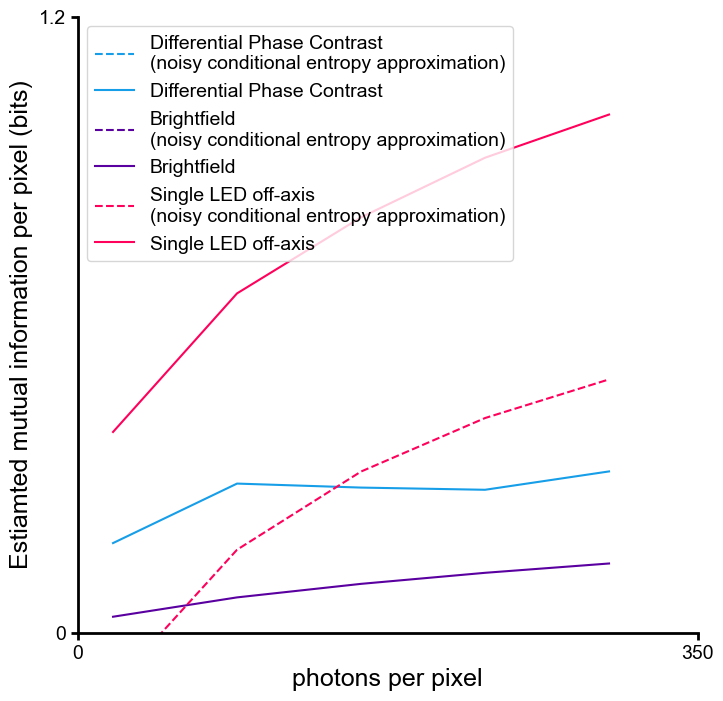

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
colors = get_color_cycle()
for color, (channel, channel_results) in zip(colors, results.items()):
    noisy_conditional_means = []
    noisy_conditional_intervals = []
    clean_conditional_means = []
    clean_conditional_intervals = []
    for noisy_conditional_mean, noisy_conditional_interval, clean_conditional_mean, clean_conditional_interval in channel_results:
        noisy_conditional_means.append(noisy_conditional_mean)
        noisy_conditional_intervals.append(noisy_conditional_interval)
        clean_conditional_means.append(clean_conditional_mean)
        clean_conditional_intervals.append(clean_conditional_interval)
    
    channel_name = get_display_channel_names(channel)
    ax.plot(photons_per_pixel_list, noisy_conditional_means, '--',label=channel_name + '\n(noisy conditional entropy approximation)', color=color)
    ax.plot(photons_per_pixel_list, clean_conditional_means, '-', label=channel_name , color=color)
default_format(ax)
ax.set(xlabel='photons per pixel', ylabel='Estiamted mutual information per pixel (bits)')
ax.legend()

## Computing conditional entropy from the raw samples vs a stationary process approximation of the samples

In [5]:
size = 50
num_images = 10000
photons_per_pixel = 200
channels = ['DPC_Right', 'Brightfield', 'LED119']
# channels = ['LED119']

experimental_images = {}
stationary_process_samples = {}
for channel in tqdm(channels):
    experimental_images[channel] = load_or_sample_images(size, 'led_array', num_images, channel=channel, median_filter=True, edge_crop=32)
    samples, cov_mat = load_or_sample_images(size, 'stationary_GP', num_images, channel=channel, median_filter=True, edge_crop=32)  
    stationary_process_samples[channel] = samples
    for im in [experimental_images[channel], stationary_process_samples[channel]]:
        if np.min(im) < 0:
            raise ValueError('images must be nonnegative')

mean_photons = {channel: np.mean(experimental_images[channel]) for channel in experimental_images.keys()}
results = {}
for channel in tqdm(channels):
    rescale_fractions = photons_per_pixel / mean_photons[channel]
    noisy_images = np.array(add_shot_noise(experimental_images[channel] * rescale_fractions[channel]))
    noisy_stationary_process_samples = np.array(add_shot_noise(stationary_process_samples[channel] * rescale_fractions[channel]))

    mi_experimental = estimate_mutual_information(noisy_images) 
    mi_stationary = estimate_mutual_information(noisy_images, clean_images=noisy_stationary_process_samples)
    results[channel] = {'experimental': mi_experimental, 'stationary': mi_stationary}


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:00<00:00, 932245.72it/s]


computing cov mat


100%|██████████| 99/99 [00:02<00:00, 34.84it/s]
/tmp/ipykernel_24998/2370822704.py:35: UserWarning: Making covariance matrix symmetric, current deviation is 0.0022873040288686752% of the mean
  warnings.warn(f'Making covariance matrix symmetric, current deviation is {np.max(percentage_error)}% of the mean')


making positive definite
Matrix not positive definite. Adding 93.9415054321289 to eigenvalues
precomputing masks and variances


100%|██████████| 50000/50000 [00:00<00:00, 909259.29it/s]


computing cov mat


100%|██████████| 99/99 [00:02<00:00, 34.94it/s]
/tmp/ipykernel_24998/2370822704.py:35: UserWarning: Making covariance matrix symmetric, current deviation is 0.0011833958560600877% of the mean
  warnings.warn(f'Making covariance matrix symmetric, current deviation is {np.max(percentage_error)}% of the mean')


making positive definite
Matrix not positive definite. Adding 26.421173095703125 to eigenvalues
precomputing masks and variances


100%|██████████| 50/50 [00:04<00:00, 10.14it/s]


## TODO: the bar chart for figure 2

In [ ]:
# create sample data
channel_names = ['Channel 1', 'Channel 2', 'Channel 3']
experimental_data = [10, 20, 30]
non_experimental_data = [15, 25, 35]

# create a paired bar plot of results
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
colors = get_color_cycle()

# set the width of the bars
bar_width = 0.35

# create the bar plots
experimental_bars = ax.bar(np.arange(len(channel_names)), experimental_data, width=bar_width, color=colors[0], label='Experimental')
non_experimental_bars = ax.bar(np.arange(len(channel_names)) + bar_width, non_experimental_data, width=bar_width, color=colors[1], label='Non-experimental')

# add labels, title, and legend
ax.set_xticks(np.arange(len(channel_names)) + bar_width / 2)
ax.set_xticklabels(channel_names)
ax.set_ylabel('Data')
ax.set_title('Experimental vs Non-experimental Data')
ax.legend()

## Whats happening here??? Why does addin shot noise to experimental data not work?

In [105]:
edge_crop = 24
patch_size = 50
channel = 'LED119'

num_images = 10000
num_patches = 10000

photons_per_pixel = 150

images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

noisy_patches = add_shot_noise_to_experimenal_data(patches, photon_fraction=photons_per_pixel / np.mean(images))
# noisy_patches = add_shot_noise(patches * photons_per_pixel / np.mean(images))
estimate_mutual_information(noisy_patches, show_eigenvalue_plot=False, eigenvalue_floor=1, verbose=True)

# cov_mat = compute_stationary_cov_mat(noisy_patches, verbose=True)
# evs = np.linalg.eigvalsh(cov_mat)

# # plot them
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# ax.semilogy(evs)

100%|██████████| 10000/10000 [00:00<00:00, 476755.48it/s]


Estimated H(Y|X) = 5.585 bits/pixel
Estimated H(Y) = 5.396 bits/pixel
Estimated I(Y;X) = -0.189 bits/pixel


Array(-0.18947697, dtype=float32)

## Information vs number of photons

In [106]:
edge_crop = 24
patch_size = 20

num_images = 5000
num_patches = 10000

photons_per_pixel_values = onp.linspace(20, 300, 5)

channel = 'LED119'
confidence_interval = 90


images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

mi_means = []
mi_confidences = []

for photons_per_pixel in tqdm(photons_per_pixel_values):
    # noisy_patches = add_shot_noise_to_experimenal_data(patches, photon_fraction=photons_per_pixel / np.mean(images))
    noisy_patches = add_shot_noise(patches * photons_per_pixel / np.mean(images))

    mi_mean, mi_confidence = estimate_mutual_information(noisy_patches, show_eigenvalue_plot=False, eigenvalue_floor=1, 
                                                         confidence_interval=confidence_interval, num_bootstrap_samples=100)
    mi_means.append(mi_mean)
    mi_confidences.append(mi_confidence)

mi_means = np.array(mi_means)
mi_confidences = np.array(mi_confidences)



100%|██████████| 5/5 [02:32<00:00, 30.53s/it]


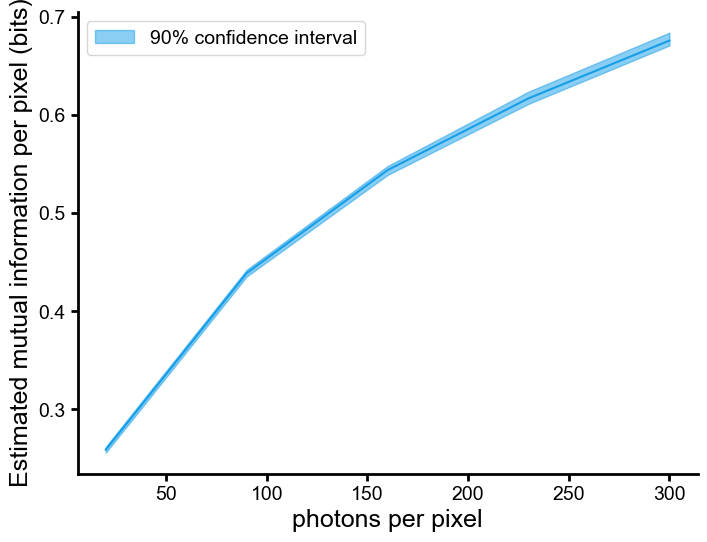

: 

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
colors = get_color_cycle()
ax.plot(photons_per_pixel_values, mi_means, color=colors[0])
ax.fill_between(photons_per_pixel_values, onp.array(mi_confidences)[:, 0], onp.array(mi_confidences)[:, 1], color=colors[0], alpha=0.5, label='90% confidence interval')
clear_spines(ax)
ax.set(xlabel='photons per pixel', ylabel='Estimated mutual information per pixel (bits)')
# show legend fo confidence interval
ax.legend()

## How do samples from GP approx look like with different patch sizes:
- starting from 1 pixel
- maybe this belongs in the other notebook